In [ ]:
!pip install tensorflow opencv-python-headless matplotlib seaborn scikit-learn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from pathlib import Path

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!unzip '/content/drive/MyDrive/Emotion Dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: images/validation/fear/8797.jpg  
  inflating: images/validation/fear/8818.jpg  
  inflating: images/validation/fear/886.jpg  
  inflating: images/validation/fear/9037.jpg  
  inflating: images/validation/fear/9040.jpg  
  inflating: images/validation/fear/9101.jpg  
  inflating: images/validation/fear/911.jpg  
  inflating: images/validation/fear/9179.jpg  
  inflating: images/validation/fear/9205.jpg  
  inflating: images/validation/fear/9232.jpg  
  inflating: images/validation/fear/9251.jpg  
  inflating: images/validation/fear/9261.jpg  
  inflating: images/validation/fear/9281.jpg  
  inflating: images/validation/fear/9302.jpg  
  inflating: images/validation/fear/9333.jpg  
  inflating: images/validation/fear/9369.jpg  
  inflating: images/validation/fear/9370.jpg  
  inflating: images/validation/fear/9474.jpg  
  inflating: images/validation/fear/949.jpg  
  inflating: images/validation/fear/9602.jpg  
  inflating:

In [ ]:
DATASET_PATH = '/content/images'  # Update this path!

TRAIN_DIR = os.path.join(DATASET_PATH, 'train')
TEST_DIR = os.path.join(DATASET_PATH, 'validation')

In [ ]:
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64

In [ ]:
EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

print(f"Dataset path: {DATASET_PATH}")
print(f"Training directory: {TRAIN_DIR}")
print(f"Testing directory: {TEST_DIR}")

Dataset path: /content/images
Training directory: /content/images/train
Testing directory: /content/images/validation


In [ ]:
# Count images in each emotion category
def count_images(directory):
    counts = {}
    for emotion in EMOTIONS:
        emotion_path = os.path.join(directory, emotion)
        if os.path.exists(emotion_path):
            counts[emotion] = len(os.listdir(emotion_path))
        else:
            counts[emotion] = 0
    return counts

train_counts = count_images(TRAIN_DIR)
test_counts = count_images(TEST_DIR)

print("\n=== Training Set Distribution ===")
for emotion, count in train_counts.items():
    print(f"{emotion.capitalize()}: {count} images")

print(f"\nTotal Training Images: {sum(train_counts.values())}")

print("\n=== Test Set Distribution ===")
for emotion, count in test_counts.items():
    print(f"{emotion.capitalize()}: {count} images")

print(f"\nTotal Test Images: {sum(test_counts.values())}")


=== Training Set Distribution ===
Angry: 3993 images
Disgust: 436 images
Fear: 4103 images
Happy: 7164 images
Sad: 4938 images
Surprise: 3205 images
Neutral: 4982 images

Total Training Images: 28821

=== Test Set Distribution ===
Angry: 960 images
Disgust: 111 images
Fear: 1018 images
Happy: 1825 images
Sad: 1139 images
Surprise: 797 images
Neutral: 1216 images

Total Test Images: 7066


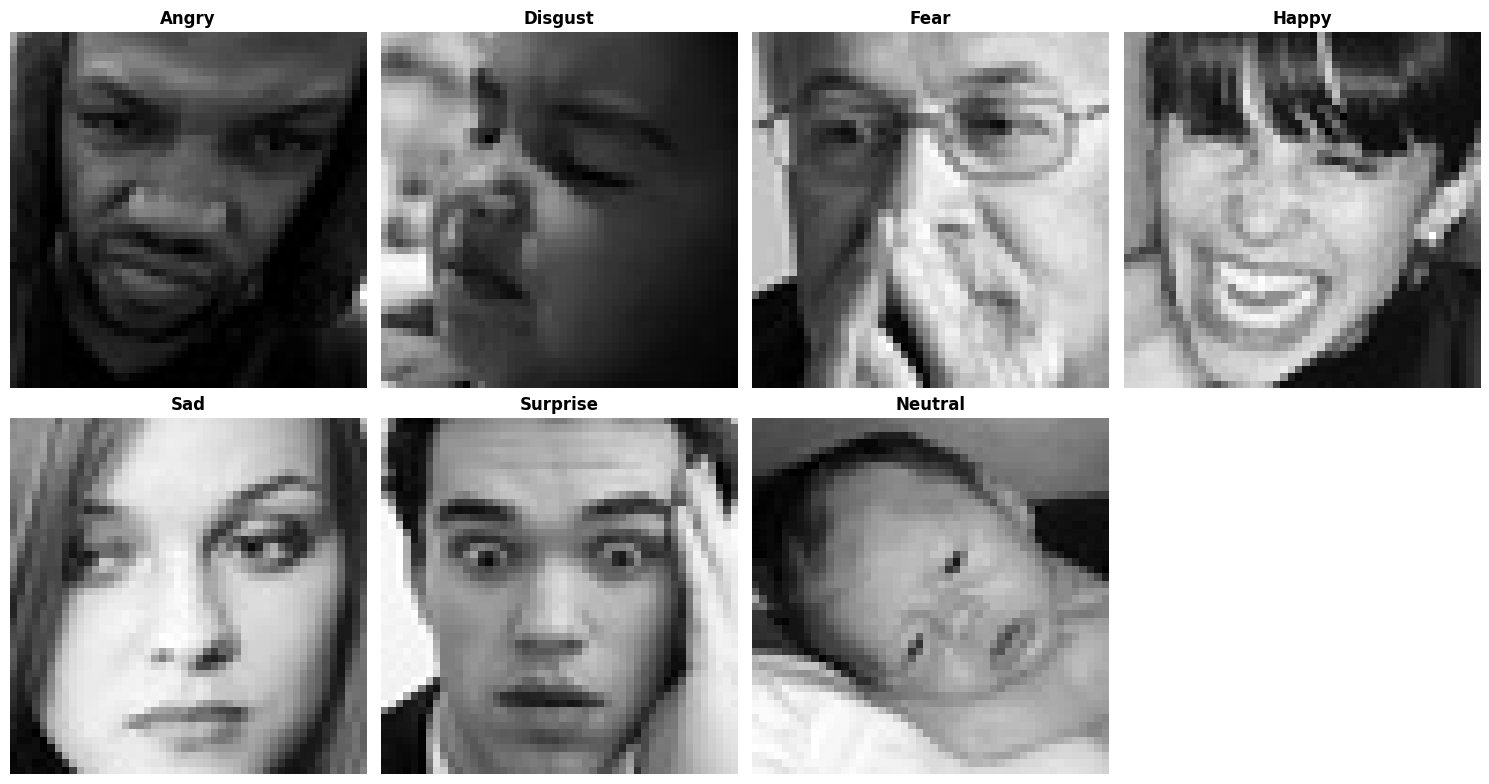

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.ravel()

for i, emotion in enumerate(EMOTIONS):
    emotion_path = os.path.join(TRAIN_DIR, emotion)
    if os.path.exists(emotion_path):
        image_files = os.listdir(emotion_path)
        if image_files:
            sample_image = cv2.imread(os.path.join(emotion_path, image_files[0]), cv2.IMREAD_GRAYSCALE)
            axes[i].imshow(sample_image, cmap='gray')
            axes[i].set_title(f'{emotion.capitalize()}', fontsize=12, fontweight='bold')
            axes[i].axis('off')

# Remove extra subplot
fig.delaxes(axes[7])
plt.tight_layout()
plt.show()

In [ ]:
# Training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to [0, 1]
    rotation_range=20,           # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,       # Randomly shift images horizontally
    height_shift_range=0.2,      # Randomly shift images vertically
    horizontal_flip=True,        # Randomly flip images horizontally
    zoom_range=0.2,              # Randomly zoom into images
    fill_mode='nearest',         # Fill empty pixels with nearest value
    validation_split=0.2         # Use 20% of training data for validation
)

In [ ]:
# Test data (only rescaling, no augmentation)
test_datagen = ImageDataGenerator(
    rescale=1./255
)


In [ ]:

# Create training generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',      # Load as grayscale
    class_mode='categorical',    # Multi-class classification
    subset='training',           # Use training subset
    shuffle=True
)

Found 23060 images belonging to 7 classes.


In [ ]:

# Create validation generator
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation',         # Use validation subset
    shuffle=False
)

Found 5761 images belonging to 7 classes.


In [ ]:

# Create test generator
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)

print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"\nClass indices: {train_generator.class_indices}")


Found 7066 images belonging to 7 classes.

Training samples: 23060
Validation samples: 5761
Test samples: 7066

Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


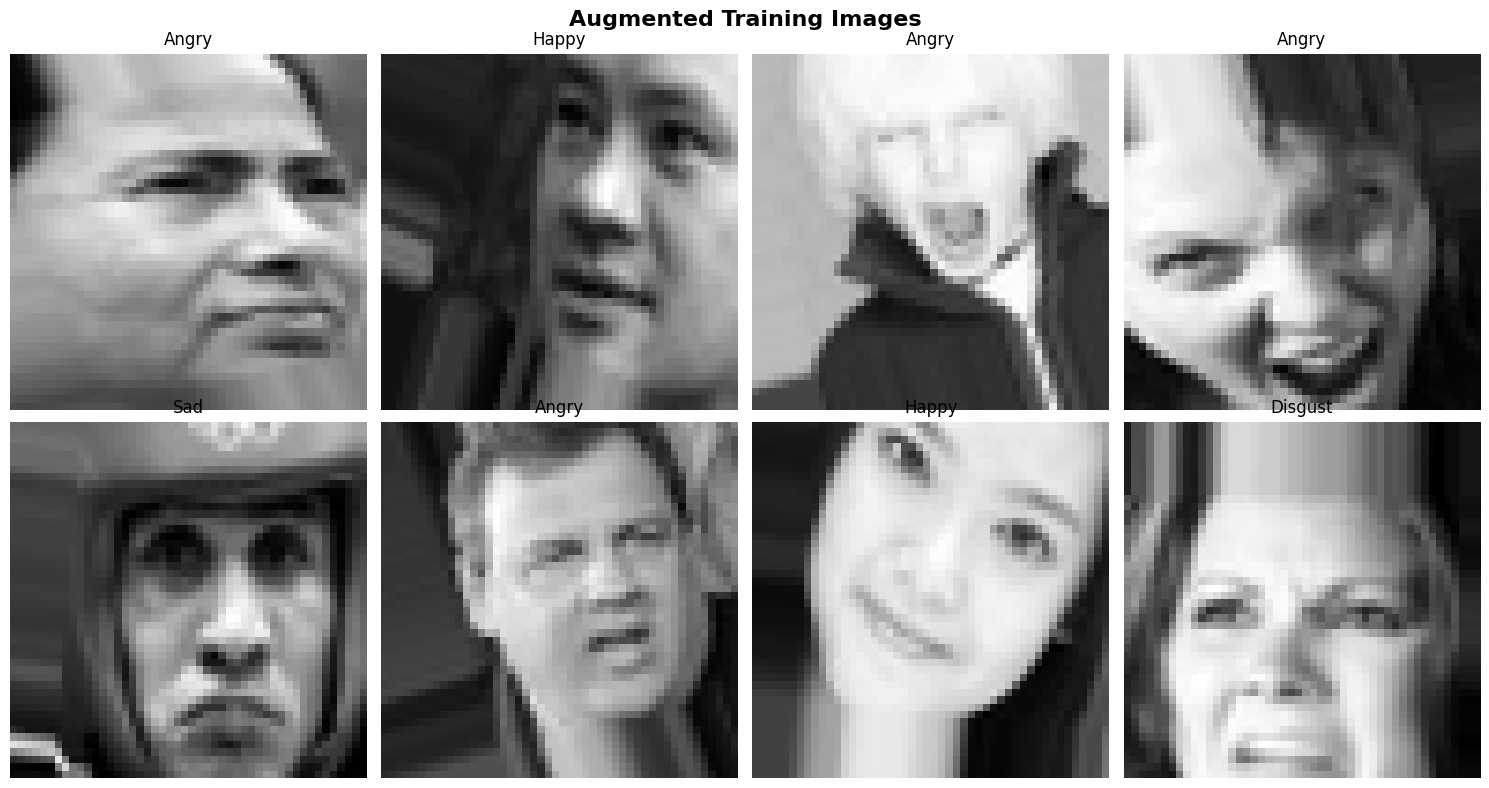

In [ ]:
# Show effect of data augmentation
sample_batch, sample_labels = next(train_generator)

fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.ravel()

for i in range(8):
    axes[i].imshow(sample_batch[i].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
    emotion_idx = np.argmax(sample_labels[i])
    emotion_name = list(train_generator.class_indices.keys())[emotion_idx]
    axes[i].set_title(f'{emotion_name.capitalize()}', fontsize=12)
    axes[i].axis('off')

plt.suptitle('Augmented Training Images', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
def create_emotion_model():
    """
    Create a CNN model for emotion recognition
    """
    model = models.Sequential([
        # Input layer
        layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1)),

        # First Convolutional Block
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Fourth Convolutional Block
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Flatten and Dense Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # Output layer (7 emotions)
        layers.Dense(7, activation='softmax')
    ])

    return model

In [ ]:

# Create the model
model = create_emotion_model()


In [ ]:

# Display model architecture
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,491,879 (9.51 MB)

 Trainable params: 2,488,423 (9.49 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [ ]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),          # Adam optimizer with learning rate
    loss='categorical_crossentropy',                # Loss for multi-class classification
    metrics=['accuracy']                            # Track accuracy
)

print("Model compiled successfully!")


Model compiled successfully!


In [ ]:
# Create directory for saving models
MODEL_DIR = '/content/emotion_models'
os.makedirs(MODEL_DIR, exist_ok=True)

In [ ]:
# Define callbacks
checkpoint = ModelCheckpoint(
    filepath=os.path.join(MODEL_DIR, 'emotion_model_best.keras'),
    monitor='val_accuracy',      # Monitor validation accuracy
    save_best_only=True,         # Only save when it's the best
    mode='max',                  # Maximize accuracy
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',          # Monitor validation loss
    patience=15,                 # Wait 15 epochs before stopping
    restore_best_weights=True,   # Restore best weights
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',          # Monitor validation loss
    factor=0.5,                  # Reduce LR by half
    patience=5,                  # Wait 5 epochs before reducing
    min_lr=0.00001,              # Minimum learning rate
    verbose=1
)

callbacks = [checkpoint, early_stopping, reduce_lr]

print("Callbacks configured!")

Callbacks configured!


In [ ]:
# Training parameters
EPOCHS = 5  # Maximum number of epochs (early stopping may stop earlier)

print("Starting training...\n")
print(f"Total epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Steps per epoch: {train_generator.samples // BATCH_SIZE}")
print(f"Validation steps: {validation_generator.samples // BATCH_SIZE}")
print("\n" + "="*70 + "\n")

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*70)
print("Training completed!")
print("="*70)


Starting training...

Total epochs: 5
Batch size: 64
Steps per epoch: 360
Validation steps: 90


Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.1535 - loss: 3.0445
Epoch 1: val_accuracy improved from -inf to 0.20799, saving model to /content/emotion_models/emotion_model_best.keras
360/360 ━━━━━━━━━━━━━━━━━━━━ 56s 101ms/step - accuracy: 0.1535 - loss: 3.0441 - val_accuracy: 0.2080 - val_loss: 2.0149 - learning_rate: 1.0000e-04
Epoch 2/5
  1/360 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.1250 - loss: 3.0500

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.20799
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1250 - loss: 3.0500 - val_accuracy: 0.2071 - val_loss: 2.0213 - learning_rate: 1.0000e-04
Epoch 3/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.1738 - loss: 2.6702
Epoch 3: val_accuracy improved from 0.20799 to 0.21458, saving model to /content/emotion_models/emotion_model_best.keras
360/360 ━━━━━━━━━━━━━━━━━━━━ 24s 67ms/step - accuracy: 0.1738 - loss: 2.6700 - val_accuracy: 0.2146 - val_loss: 2.0164 - learning_rate: 1.0000e-04
Epoch 4/5
  1/360 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.1562 - loss: 2.3971
Epoch 4: val_accuracy did not improve from 0.21458
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.1562 - loss: 2.3971 - val_accuracy: 0.2062 - val_loss: 2.0225 - learning_rate: 1.0000e-04
Epoch 5/5
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.1827 - loss: 2.4718
Epoch 5: val_accuracy improved from 0.21458 to 0.24097, saving model to /conte

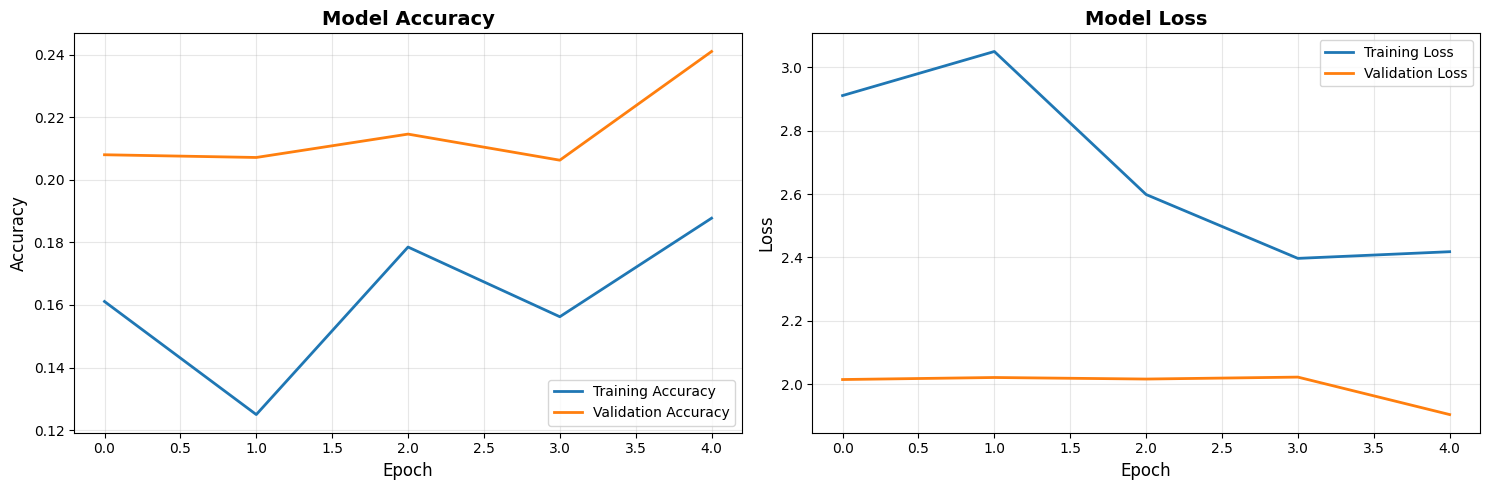


Final Training Accuracy: 0.1877
Final Validation Accuracy: 0.2410
Final Training Loss: 2.4182
Final Validation Loss: 1.9043


In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
print(f"\nFinal Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")


In [ ]:
# Evaluate on test set
print("Evaluating model on test set...\n")

test_loss, test_accuracy = model.evaluate(
    test_generator,
    steps=test_generator.samples // BATCH_SIZE
)

print(f"\n{'='*50}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")
print(f"{'='*50}")

Evaluating model on test set...

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.1924 - loss: 2.1095

Test Accuracy: 0.2730 (27.30%)
Test Loss: 1.8498


In [ ]:
# Generate predictions
print("Generating predictions...")
test_generator.reset()
predictions = model.predict(
    test_generator,
    steps=test_generator.samples // BATCH_SIZE + 1
)

# Get predicted classes
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = test_generator.classes[:len(predicted_classes)]

# Class labels
class_labels = list(test_generator.class_indices.keys())

print("\n=== Classification Report ===")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


Generating predictions...
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step

=== Classification Report ===
              precision    recall  f1-score   support

       angry       0.28      0.01      0.02       960
     disgust       0.00      0.00      0.00       111
        fear       0.17      0.01      0.01      1018
       happy       0.30      0.66      0.42      1825
     neutral       0.22      0.42      0.29      1216
         sad       0.23      0.08      0.12      1139
    surprise       0.35      0.12      0.18       797

    accuracy                           0.27      7066
   macro avg       0.22      0.19      0.15      7066
weighted avg       0.26      0.27      0.20      7066



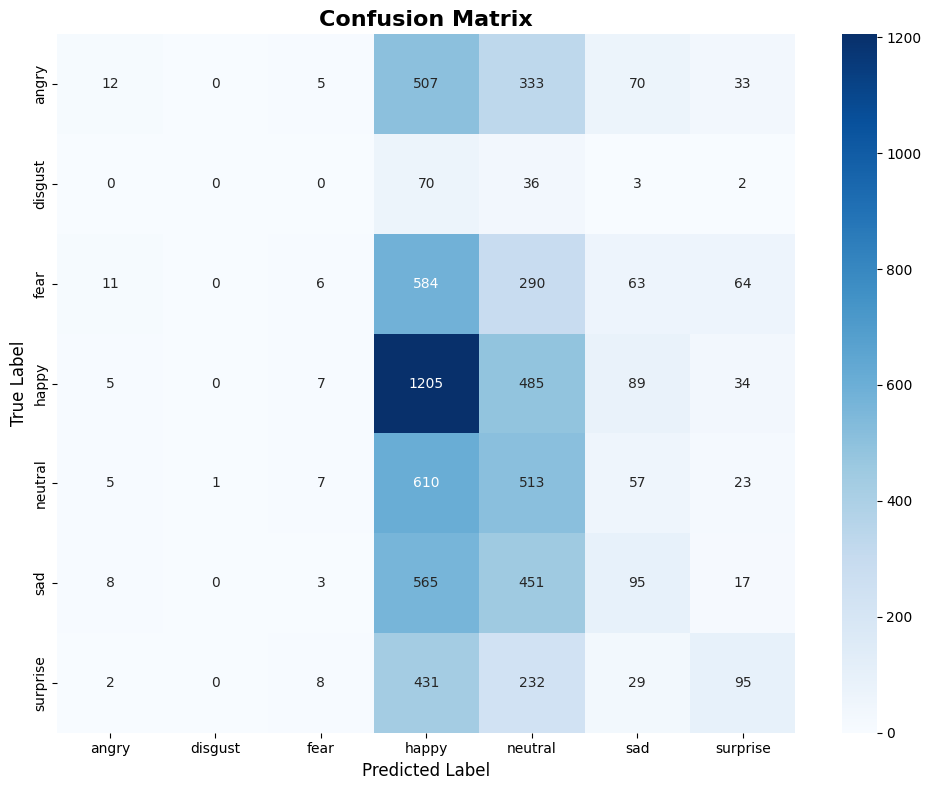

In [ ]:
# Create confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


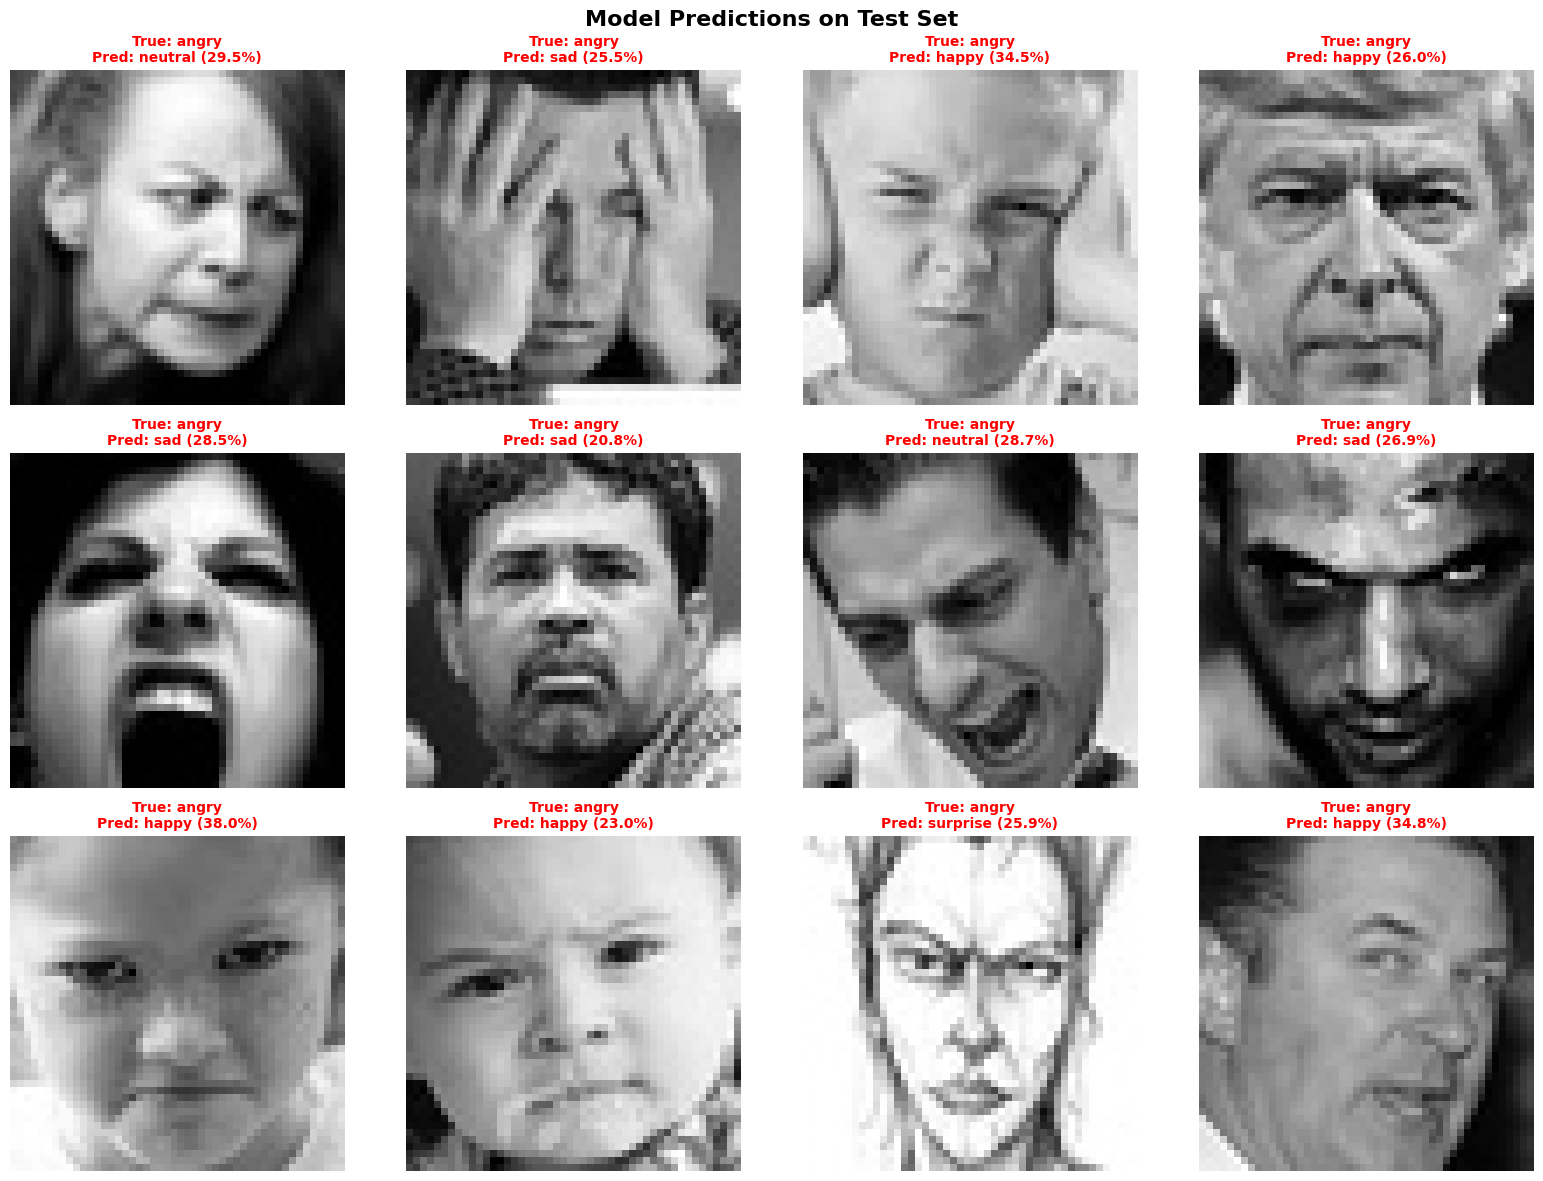

In [ ]:
# Visualize some predictions
test_generator.reset()
test_images, test_labels = next(test_generator)

# Make predictions
predictions_batch = model.predict(test_images)

# Plot results
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

for i in range(12):
    # Display image
    axes[i].imshow(test_images[i].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')

    # Get true and predicted labels
    true_label = class_labels[np.argmax(test_labels[i])]
    pred_label = class_labels[np.argmax(predictions_batch[i])]
    confidence = np.max(predictions_batch[i]) * 100

    # Color: green if correct, red if wrong
    color = 'green' if true_label == pred_label else 'red'

    axes[i].set_title(
        f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)',
        color=color,
        fontsize=10,
        fontweight='bold'
    )
    axes[i].axis('off')

plt.suptitle('Model Predictions on Test Set', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
# Save the final model
final_model_path = os.path.join(MODEL_DIR, 'emotion_model_final.keras')
model.save('my_model.keras')
print(f"Model saved to: {final_model_path}")

# Also save in H5 format (compatible with older systems)
h5_model_path = os.path.join(MODEL_DIR, 'emotion_model_final.h5')
model.save('my_model.keras')
print(f"Model also saved as H5 format: {h5_model_path}")


Model saved to: /content/emotion_models/emotion_model_final.keras
Model also saved as H5 format: /content/emotion_models/emotion_model_final.h5


In [ ]:
# Load Haar Cascade for face detection
face_cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(face_cascade_path)

In [ ]:

# # Emotion labels
# emotion_labels = list(train_generator.class_indices.keys())

# def detect_emotion_in_image(image_path, model, face_cascade):
#     """
#     Detect and predict emotions in an image
#     """
#     # Read image
#     img = cv2.imread(image_path)
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#     # Detect faces
#     faces = face_cascade.detectMultiScale(
#         gray,
#         scaleFactor=1.1,
#         minNeighbors=5,
#         minSize=(30, 30)
#     )

#     # Process each face
#     for (x, y, w, h) in faces:
#         # Extract face ROI
#         face_roi = gray[y:y+h, x:x+w]

#         # Preprocess face for model
#         face_roi = cv2.resize(face_roi, (IMG_HEIGHT, IMG_WIDTH))
#         face_roi = face_roi.astype('float32') / 255.0
#         face_roi = np.expand_dims(face_roi, axis=0)
#         face_roi = np.expand_dims(face_roi, axis=-1)

#         # Predict emotion
#         prediction = model.predict(face_roi, verbose=0)
#         emotion_idx = np.argmax(prediction)
#         emotion = emotion_labels[emotion_idx]
#         confidence = np.max(prediction) * 100

#         # Draw rectangle and text
#         cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

#         # Prepare text
#         text = f"{emotion}: {confidence:.1f}%"

#         # Draw text background
#         (text_width, text_height), _ = cv2.getTextSize(
#             text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2
#         )
#         cv2.rectangle(
#             img,
#             (x, y - text_height - 10),
#             (x + text_width, y),
#             (0, 255, 0),
#             -1
#         )

#         # Draw text
#         cv2.putText(
#             img,
#             text,
#             (x, y - 5),
#             cv2.FONT_HERSHEY_SIMPLEX,
#             0.7,
#             (0, 0, 0),
#             2
#         )

#     return img, len(faces)

# print("Real-time detection functions ready!")

Real-time detection functions ready!


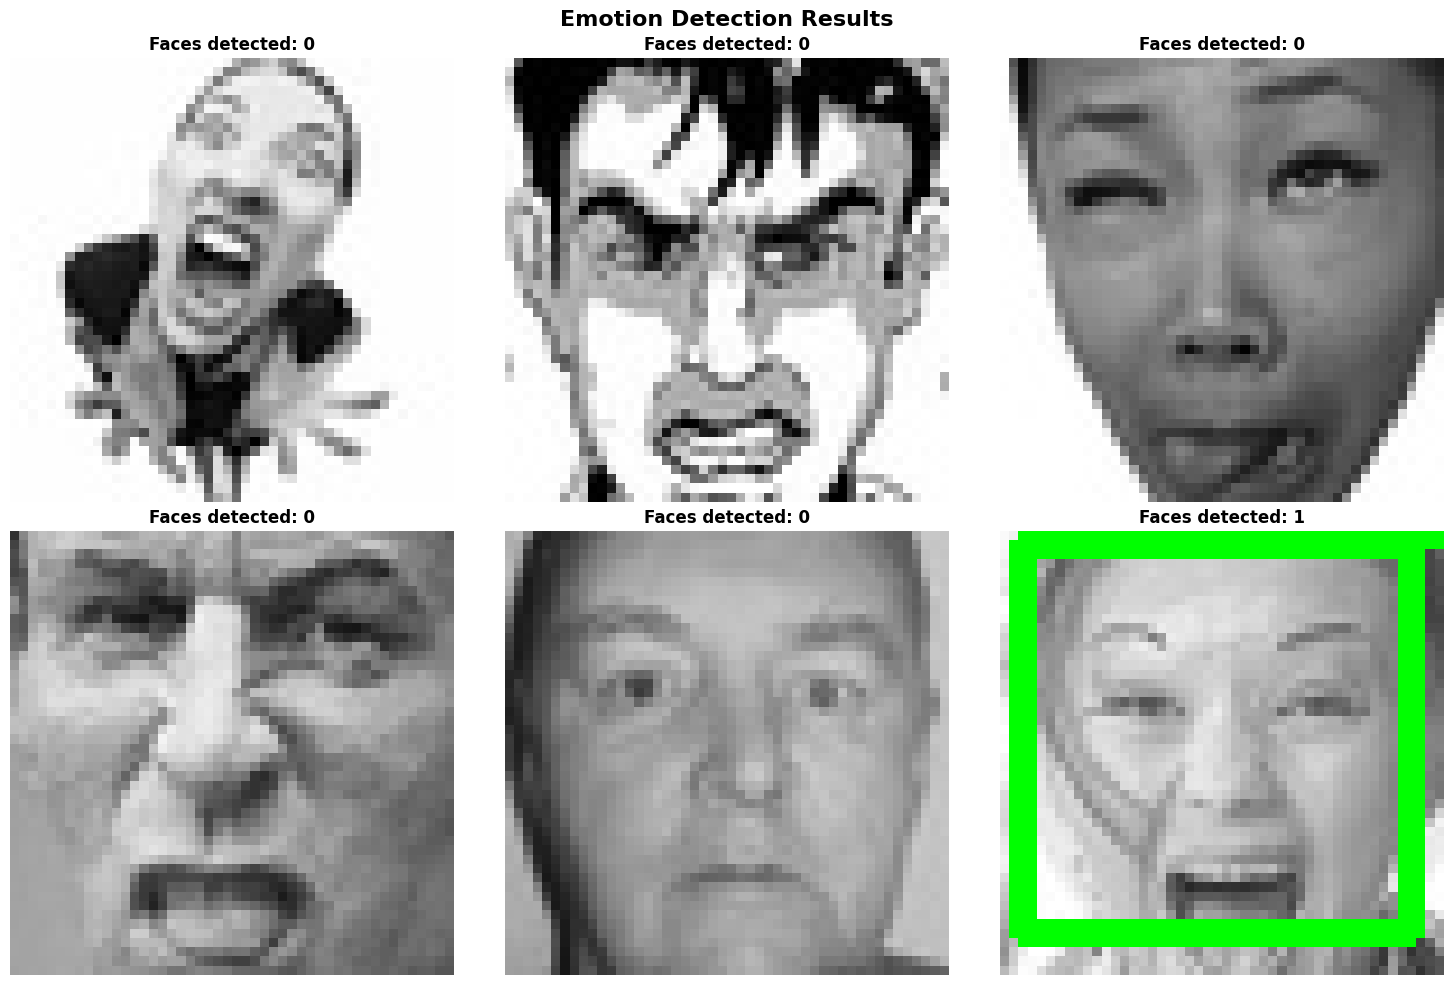

In [ ]:
# # Test on a few images from test set
# test_images_paths = []
# for emotion in emotion_labels[:3]:  # Test on first 3 emotions
#     emotion_path = os.path.join(TEST_DIR, emotion)
#     if os.path.exists(emotion_path):
#         images = os.listdir(emotion_path)[:2]  # Get 2 images per emotion
#         test_images_paths.extend([os.path.join(emotion_path, img) for img in images])

# # Process and display
# fig, axes = plt.subplots(2, 3, figsize=(15, 10))
# axes = axes.ravel()

# for i, img_path in enumerate(test_images_paths[:6]):
#     result_img, num_faces = detect_emotion_in_image(img_path, model, face_cascade)

#     # Convert BGR to RGB for display
#     result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

#     axes[i].imshow(result_img)
#     axes[i].set_title(f'Faces detected: {num_faces}', fontsize=12, fontweight='bold')
#     axes[i].axis('off')

# plt.suptitle('Emotion Detection Results', fontsize=16, fontweight='bold')
# plt.tight_layout()
# plt.show()


In [ ]:
# from google.colab import files
# from PIL import Image
# import io

# # Upload image
# print("Please upload an image:")
# uploaded = files.upload()

# # Process uploaded image
# for filename in uploaded.keys():
#     # Save temporarily
#     temp_path = f'/content/{filename}'

#     with open(temp_path, 'wb') as f:
#         f.write(uploaded[filename])

#     # Detect emotion
#     result_img, num_faces = detect_emotion_in_image(temp_path, model, face_cascade)

#     # Display result
#     plt.figure(figsize=(12, 8))
#     result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
#     plt.imshow(result_img)
#     plt.title(f'Detected {num_faces} face(s)', fontsize=14, fontweight='bold')
#     plt.axis('off')
#     plt.tight_layout()
#     plt.show()

#     print(f"\nProcessed: {filename}")
#     print(f"Faces detected: {num_faces}")

Please upload an image:


KeyboardInterrupt: 

Realtime detection

In [ ]:
# !pip install opencv-python-headless tensorflow pillow IPython

In [ ]:

# import cv2
# import numpy as np
# from tensorflow import keras
# import matplotlib.pyplot as plt
# from IPython.display import display, Javascript, Image as IPImage
# from google.colab.output import eval_js
# from base64 import b64decode, b64encode
# from PIL import Image
# import io
# import time

# print("Libraries imported successfully!")


In [ ]:
# # Load your trained emotion recognition model
# MODEL_PATH = '/content/emotion_models/emotion_model_final.keras'  # Update this!

# print("Loading model...")
# model = keras.models.load_model(MODEL_PATH)
# print("✓ Model loaded successfully!")


In [ ]:

# # Load Haar Cascade for face detection
# face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# print("✓ Face detector loaded!")


In [ ]:
# # Emotion labels (update based on your model)
# EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
# IMG_SIZE = 48

# print(f"\nDetecting emotions: {', '.join(EMOTIONS)}")


In [ ]:
# def detect_emotion_from_frame(frame_data):
#     """
#     Detect emotion from a single frame

#     Args:
#         frame_data: Base64 encoded image or numpy array

#     Returns:
#         Processed image with emotion labels
#     """
#     # Convert base64 to image if needed
#     if isinstance(frame_data, str):
#         # Decode base64 image
#         img_data = b64decode(frame_data.split(',')[1])
#         img = Image.open(io.BytesIO(img_data))
#         frame = np.array(img)
#     else:
#         frame = frame_data

#     # Convert to grayscale for face detection
#     if len(frame.shape) == 3:
#         gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
#     else:
#         gray = frame

#     # Detect faces
#     faces = face_cascade.detectMultiScale(
#         gray,
#         scaleFactor=1.1,
#         minNeighbors=5,
#         minSize=(30, 30)
#     )

#     # Process each detected face
#     for (x, y, w, h) in faces:
#         # Extract and preprocess face ROI
#         face_roi = gray[y:y+h, x:x+w]
#         face_roi = cv2.resize(face_roi, (IMG_SIZE, IMG_SIZE))
#         face_roi = face_roi.astype('float32') / 255.0
#         face_roi = np.expand_dims(face_roi, axis=0)
#         face_roi = np.expand_dims(face_roi, axis=-1)

#         # Predict emotion
#         prediction = model.predict(face_roi, verbose=0)
#         emotion_idx = np.argmax(prediction)
#         emotion = EMOTIONS[emotion_idx]
#         confidence = np.max(prediction) * 100

#         # Choose color based on emotion
#         colors = {
#             'happy': (0, 255, 0),      # Green
#             'sad': (255, 0, 0),        # Blue
#             'angry': (0, 0, 255),      # Red
#             'surprise': (255, 255, 0), # Cyan
#             'fear': (255, 0, 255),     # Magenta
#             'disgust': (0, 255, 255),  # Yellow
#             'neutral': (128, 128, 128) # Gray
#         }
#         color = colors.get(emotion, (0, 255, 0))

#         # Draw bounding box
#         cv2.rectangle(frame, (x, y), (x+w, y+h), color, 3)

#         # Prepare label text
#         label = f"{emotion.upper()}"
#         confidence_text = f"{confidence:.1f}%"

#         # Get text size for background
#         (label_w, label_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.9, 2)
#         (conf_w, conf_h), _ = cv2.getTextSize(confidence_text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)

#         # Draw label background
#         cv2.rectangle(
#             frame,
#             (x, y - label_h - conf_h - 20),
#             (x + max(label_w, conf_w) + 10, y),
#             color,
#             -1
#         )

#         # Draw emotion label
#         cv2.putText(
#             frame,
#             label,
#             (x + 5, y - conf_h - 15),
#             cv2.FONT_HERSHEY_SIMPLEX,
#             0.9,
#             (255, 255, 255),
#             2
#         )

#         # Draw confidence
#         cv2.putText(
#             frame,
#             confidence_text,
#             (x + 5, y - 5),
#             cv2.FONT_HERSHEY_SIMPLEX,
#             0.7,
#             (255, 255, 255),
#             2
#         )

#     # Add face count
#     info_text = f"Faces: {len(faces)}"
#     cv2.putText(
#         frame,
#         info_text,
#         (10, 30),
#         cv2.FONT_HERSHEY_SIMPLEX,
#         1,
#         (0, 255, 0),
#         2
#     )

#     return frame

# print("✓ Emotion detection function ready!")

In [ ]:
# from IPython.display import HTML, display
# from google.colab.patches import cv2_imshow

# def take_photo(filename='photo.jpg', quality=0.8):
#     """
#     Take a photo from webcam using JavaScript
#     """
#     js = Javascript('''
#         async function takePhoto(quality) {
#             const div = document.createElement('div');
#             const video = document.createElement('video');
#             const canvas = document.createElement('canvas');

#             // Style elements
#             div.style.position = 'relative';
#             video.style.display = 'block';
#             video.style.width = '640px';

#             // Add to page
#             document.body.appendChild(div);
#             div.appendChild(video);

#             // Get video stream
#             const stream = await navigator.mediaDevices.getUserMedia({video: true});
#             video.srcObject = stream;
#             await video.play();

#             // Wait a bit for camera to adjust
#             await new Promise(resolve => setTimeout(resolve, 1000));

#             // Capture image
#             canvas.width = video.videoWidth;
#             canvas.height = video.videoHeight;
#             canvas.getContext('2d').drawImage(video, 0, 0);
#             const img = canvas.toDataURL('image/jpeg', quality);

#             // Clean up
#             stream.getTracks().forEach(track => track.stop());
#             div.remove();

#             return img;
#         }
#     ''')
#     display(js)

#     # Get image data
#     data = eval_js('takePhoto({})'.format(quality))
#     return data

# print("✓ Photo capture function ready!")

In [ ]:
# # Real-time webcam emotion detection
# print("Starting real-time emotion detection...")
# print("Press the STOP button to end.\n")
# print("="*60)

# frame_count = 0
# try:
#     while True:
#         # Capture frame from webcam
#         print(f"\n📸 Capturing frame {frame_count + 1}...")
#         img_data = take_photo(quality=0.8)

#         # Process frame
#         processed_frame = detect_emotion_from_frame(img_data)

#         # Display result
#         print("✓ Processing complete!")
#         cv2_imshow(processed_frame)

#         frame_count += 1

#         # Wait before next capture (adjust timing as needed)
#         time.sleep(2)  # Capture every 2 seconds

# except KeyboardInterrupt:
#     print("\n" + "="*60)
#     print(f"Detection stopped. Processed {frame_count} frames.")
#     print("="*60)

In [ ]:
# # Capture single frame
# print("Capturing frame from webcam...")
# img_data = take_photo(quality=0.8)

# # Process and display
# processed_frame = detect_emotion_from_frame(img_data)
# print("✓ Emotion detection complete!\n")

# # Display result
# cv2_imshow(processed_frame)

# # Save if needed
# save_path = '/content/detected_emotion.jpg'
# cv2.imwrite(save_path, cv2.cvtColor(processed_frame, cv2.COLOR_RGB2BGR))
# print(f"\nImage saved to: {save_path}")


In [ ]:
# # Install and import required libraries
# !pip install tensorflow opencv-python-headless matplotlib seaborn scikit-learn pandas numpy

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import cv2
# import os
# from pathlib import Path

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers, models
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.regularizers import l2

# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.utils.class_weight import compute_class_weight

# # Set random seeds
# np.random.seed(42)
# tf.random.set_seed(42)

# print(f"TensorFlow version: {tf.__version__}")
# print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


# # Update these paths!
# DATASET_PATH = '/content/images'
# TRAIN_DIR = os.path.join(DATASET_PATH, 'train')
# TEST_DIR = os.path.join(DATASET_PATH, 'validation')
# MODEL_PATH = '/content/emotion_models/emotion_model_best.keras'  # Your current model

# # Image parameters
# IMG_HEIGHT = 48
# IMG_WIDTH = 48
# BATCH_SIZE = 64

# # Check if directories exist
# print("Checking directories...")
# print(f"Train directory exists: {os.path.exists(TRAIN_DIR)}")
# print(f"Test directory exists: {os.path.exists(TEST_DIR)}")



# # Count images per class
# def analyze_dataset(directory):
#     """Analyze dataset distribution"""
#     if not os.path.exists(directory):
#         print(f"❌ Directory not found: {directory}")
#         return None

#     class_counts = {}
#     for class_name in os.listdir(directory):
#         class_path = os.path.join(directory, class_name)
#         if os.path.isdir(class_path):
#             count = len([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
#             class_counts[class_name] = count

#     return class_counts

# train_counts = analyze_dataset(TRAIN_DIR)
# test_counts = analyze_dataset(TEST_DIR)

# if train_counts:
#     print("\n=== TRAINING SET ===")
#     total_train = sum(train_counts.values())
#     for emotion, count in sorted(train_counts.items()):
#         percentage = (count / total_train) * 100
#         print(f"{emotion:12} : {count:6} images ({percentage:5.2f}%)")
#     print(f"{'TOTAL':12} : {total_train:6} images")

#     # Visualize distribution
#     plt.figure(figsize=(12, 5))

#     plt.subplot(1, 2, 1)
#     plt.bar(train_counts.keys(), train_counts.values(), color='skyblue', edgecolor='black')
#     plt.xlabel('Emotion', fontsize=12)
#     plt.ylabel('Number of Images', fontsize=12)
#     plt.title('Training Data Distribution', fontsize=14, fontweight='bold')
#     plt.xticks(rotation=45)
#     plt.grid(axis='y', alpha=0.3)

#     if test_counts:
#         plt.subplot(1, 2, 2)
#         plt.bar(test_counts.keys(), test_counts.values(), color='lightcoral', edgecolor='black')
#         plt.xlabel('Emotion', fontsize=12)
#         plt.ylabel('Number of Images', fontsize=12)
#         plt.title('Test Data Distribution', fontsize=14, fontweight='bold')
#         plt.xticks(rotation=45)
#         plt.grid(axis='y', alpha=0.3)

#     plt.tight_layout()
#     plt.show()

#     # Check for imbalance
#     max_count = max(train_counts.values())
#     min_count = min(train_counts.values())
#     imbalance_ratio = max_count / min_count

#     print(f"\n📊 IMBALANCE ANALYSIS:")
#     print(f"   Max class: {max_count} images")
#     print(f"   Min class: {min_count} images")
#     print(f"   Imbalance ratio: {imbalance_ratio:.2f}:1")

#     if imbalance_ratio > 3:
#         print("   ⚠️  SEVERE CLASS IMBALANCE DETECTED!")
#         print("   → Solution: Use class weights during training")
#     elif imbalance_ratio > 2:
#         print("   ⚠️  Moderate class imbalance detected")
#         print("   → Recommendation: Consider class weights")
#     else:
#         print("   ✓ Dataset is relatively balanced")



# # Check image quality and variety
# def visualize_samples(directory, num_samples=3):
#     """Visualize sample images from each class"""
#     if not os.path.exists(directory):
#         return

#     classes = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])

#     fig, axes = plt.subplots(len(classes), num_samples, figsize=(12, 2.5*len(classes)))

#     for i, emotion in enumerate(classes):
#         emotion_path = os.path.join(directory, emotion)
#         images = [f for f in os.listdir(emotion_path) if f.endswith(('.jpg', '.png', '.jpeg'))][:num_samples]

#         for j, img_name in enumerate(images):
#             img_path = os.path.join(emotion_path, img_name)
#             img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

#             if len(classes) > 1:
#                 ax = axes[i, j]
#             else:
#                 ax = axes[j]

#             if img is not None:
#                 ax.imshow(img, cmap='gray')
#                 ax.set_title(f"{emotion}\n{img.shape}", fontsize=10)
#                 ax.axis('off')

#                 # Check image statistics
#                 if j == 0:
#                     print(f"{emotion:12} - Shape: {img.shape}, Mean: {img.mean():.1f}, Std: {img.std():.1f}")

#     plt.tight_layout()
#     plt.show()

# print("\n=== SAMPLE IMAGES ===")
# visualize_samples(TRAIN_DIR, num_samples=3)



# # Load and evaluate current model (if it exists)
# if os.path.exists(MODEL_PATH):
#     print("Loading your current model...")
#     try:
#         current_model = keras.models.load_model(MODEL_PATH)
#         print("✓ Model loaded successfully\n")

#         # Show model summary
#         print("=== CURRENT MODEL ARCHITECTURE ===")
#         current_model.summary()

#         # Create test generator
#         test_datagen = ImageDataGenerator(rescale=1./255)
#         test_generator = test_datagen.flow_from_directory(
#             TEST_DIR,
#             target_size=(IMG_HEIGHT, IMG_WIDTH),
#             batch_size=BATCH_SIZE,
#             color_mode='grayscale',
#             class_mode='categorical',
#             shuffle=False
#         )

#         # Evaluate
#         print("\n=== CURRENT MODEL PERFORMANCE ===")
#         loss, accuracy = current_model.evaluate(test_generator)
#         print(f"\nTest Accuracy: {accuracy*100:.2f}%")
#         print(f"Test Loss: {loss:.4f}")

#         # Predictions for confusion matrix
#         test_generator.reset()
#         predictions = current_model.predict(test_generator, steps=len(test_generator))
#         predicted_classes = np.argmax(predictions, axis=1)
#         true_classes = test_generator.classes[:len(predicted_classes)]

#         # Confusion matrix
#         cm = confusion_matrix(true_classes, predicted_classes)
#         class_names = list(test_generator.class_indices.keys())

#         plt.figure(figsize=(10, 8))
#         sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#                    xticklabels=class_names, yticklabels=class_names)
#         plt.title('Current Model - Confusion Matrix', fontsize=14, fontweight='bold')
#         plt.ylabel('True Label')
#         plt.xlabel('Predicted Label')
#         plt.tight_layout()
#         plt.show()

#         # Classification report
#         print("\n=== DETAILED METRICS ===")
#         print(classification_report(true_classes, predicted_classes, target_names=class_names))

#     except Exception as e:
#         print(f"❌ Error loading model: {e}")
# else:
#     print("No existing model found. We'll train a new one!")



# # Better data augmentation
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest',
#     validation_split=0.2
# )

# test_datagen = ImageDataGenerator(rescale=1./255)

# # Create generators
# train_generator = train_datagen.flow_from_directory(
#     TRAIN_DIR,
#     target_size=(IMG_HEIGHT, IMG_WIDTH),
#     batch_size=BATCH_SIZE,
#     color_mode='grayscale',
#     class_mode='categorical',
#     subset='training',
#     shuffle=True
# )

# validation_generator = train_datagen.flow_from_directory(
#     TRAIN_DIR,
#     target_size=(IMG_HEIGHT, IMG_WIDTH),
#     batch_size=BATCH_SIZE,
#     color_mode='grayscale',
#     class_mode='categorical',
#     subset='validation',
#     shuffle=False
# )

# test_generator = test_datagen.flow_from_directory(
#     TEST_DIR,
#     target_size=(IMG_HEIGHT, IMG_WIDTH),
#     batch_size=BATCH_SIZE,
#     color_mode='grayscale',
#     class_mode='categorical',
#     shuffle=False
# )

# print(f"Training samples: {train_generator.samples}")
# print(f"Validation samples: {validation_generator.samples}")
# print(f"Test samples: {test_generator.samples}")
# print(f"Number of classes: {train_generator.num_classes}")
# print(f"Class indices: {train_generator.class_indices}")



# # Compute class weights to handle imbalance
# if train_counts:
#     # Get class labels
#     class_labels = sorted(train_counts.keys())
#     class_weights_array = compute_class_weight(
#         class_weight='balanced',
#         classes=np.array(range(len(class_labels))),
#         y=train_generator.classes
#     )

#     # Create dictionary
#     class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

#     print("\n=== CLASS WEIGHTS ===")
#     for emotion, idx in sorted(train_generator.class_indices.items(), key=lambda x: x[1]):
#         print(f"{emotion:12} : {class_weights[idx]:.4f}")
# else:
#     class_weights = None
#     print("No class weights calculated")


# def create_improved_model_v1():
#     """
#     Improved CNN with better regularization and architecture
#     Expected accuracy: 55-65%
#     """
#     model = models.Sequential([
#         # Input layer
#         layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1)),

#         # Block 1
#         layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.001)),
#         layers.BatchNormalization(),
#         layers.Activation('relu'),
#         layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.001)),
#         layers.BatchNormalization(),
#         layers.Activation('relu'),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Dropout(0.25),

#         # Block 2
#         layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.001)),
#         layers.BatchNormalization(),
#         layers.Activation('relu'),
#         layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.001)),
#         layers.BatchNormalization(),
#         layers.Activation('relu'),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Dropout(0.25),

#         # Block 3
#         layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.001)),
#         layers.BatchNormalization(),
#         layers.Activation('relu'),
#         layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.001)),
#         layers.BatchNormalization(),
#         layers.Activation('relu'),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Dropout(0.3),

#         # Block 4
#         layers.Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(0.001)),
#         layers.BatchNormalization(),
#         layers.Activation('relu'),
#         layers.GlobalAveragePooling2D(),

#         # Dense layers
#         layers.Dense(512, kernel_regularizer=l2(0.001)),
#         layers.BatchNormalization(),
#         layers.Activation('relu'),
#         layers.Dropout(0.5),

#         layers.Dense(256, kernel_regularizer=l2(0.001)),
#         layers.BatchNormalization(),
#         layers.Activation('relu'),
#         layers.Dropout(0.5),

#         # Output layer
#         layers.Dense(7, activation='softmax')
#     ])

#     return model

# model_v1 = create_improved_model_v1()
# model_v1.summary()





# def residual_block(x, filters, kernel_size=3):
#     """Create a residual block"""
#     # Shortcut
#     shortcut = x

#     # Main path
#     x = layers.Conv2D(filters, kernel_size, padding='same', kernel_regularizer=l2(0.001))(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)

#     x = layers.Conv2D(filters, kernel_size, padding='same', kernel_regularizer=l2(0.001))(x)
#     x = layers.BatchNormalization()(x)

#     # Match dimensions if needed
#     if shortcut.shape[-1] != filters:
#         shortcut = layers.Conv2D(filters, 1, padding='same')(shortcut)

#     # Add shortcut
#     x = layers.Add()([x, shortcut])
#     x = layers.Activation('relu')(x)

#     return x

# def create_improved_model_v2():
#     """
#     ResNet-inspired architecture with skip connections
#     Expected accuracy: 60-70%
#     """
#     inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))

#     # Initial conv
#     x = layers.Conv2D(64, 7, strides=2, padding='same', kernel_regularizer=l2(0.001))(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

#     # Residual blocks
#     x = residual_block(x, 64)
#     x = residual_block(x, 64)
#     x = layers.MaxPooling2D(2)(x)
#     x = layers.Dropout(0.25)(x)

#     x = residual_block(x, 128)
#     x = residual_block(x, 128)
#     x = layers.MaxPooling2D(2)(x)
#     x = layers.Dropout(0.3)(x)

#     x = residual_block(x, 256)
#     x = residual_block(x, 256)
#     x = layers.GlobalAveragePooling2D()(x)

#     # Dense layers
#     x = layers.Dense(512, kernel_regularizer=l2(0.001))(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = layers.Dropout(0.5)(x)

#     outputs = layers.Dense(7, activation='softmax')(x)

#     model = models.Model(inputs=inputs, outputs=outputs)
#     return model

# model_v2 = create_improved_model_v2()
# print("\n=== Model V2 (ResNet-Inspired) ===")
# model_v2.summary()




# def attention_block(x, filters):
#     """Spatial attention mechanism"""
#     # Channel attention
#     avg_pool = layers.GlobalAveragePooling2D()(x)
#     max_pool = layers.GlobalMaxPooling2D()(x)

#     avg_pool = layers.Reshape((1, 1, filters))(avg_pool)
#     max_pool = layers.Reshape((1, 1, filters))(max_pool)

#     concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
#     attention = layers.Conv2D(filters, 1, activation='sigmoid', padding='same')(concat)

#     return layers.Multiply()([x, attention])

# def create_improved_model_v3():
#     """
#     Attention-based CNN for better feature focus
#     Expected accuracy: 62-72%
#     """
#     inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))

#     # Block 1
#     x = layers.Conv2D(64, 3, padding='same', kernel_regularizer=l2(0.001))(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = layers.Conv2D(64, 3, padding='same', kernel_regularizer=l2(0.001))(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = attention_block(x, 64)
#     x = layers.MaxPooling2D(2)(x)
#     x = layers.Dropout(0.25)(x)

#     # Block 2
#     x = layers.Conv2D(128, 3, padding='same', kernel_regularizer=l2(0.001))(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = layers.Conv2D(128, 3, padding='same', kernel_regularizer=l2(0.001))(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = attention_block(x, 128)
#     x = layers.MaxPooling2D(2)(x)
#     x = layers.Dropout(0.3)(x)

#     # Block 3
#     x = layers.Conv2D(256, 3, padding='same', kernel_regularizer=l2(0.001))(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = layers.Conv2D(256, 3, padding='same', kernel_regularizer=l2(0.001))(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = attention_block(x, 256)
#     x = layers.GlobalAveragePooling2D()(x)

#     # Dense layers
#     x = layers.Dense(512, kernel_regularizer=l2(0.001))(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = layers.Dropout(0.5)(x)

#     x = layers.Dense(256, kernel_regularizer=l2(0.001))(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = layers.Dropout(0.5)(x)

#     outputs = layers.Dense(7, activation='softmax')(x)

#     model = models.Model(inputs=inputs, outputs=outputs)
#     return model

# model_v3 = create_improved_model_v3()
# print("\n=== Model V3 (Attention-Based) ===")
# model_v3.summary()




# # Choose which model to use (1, 2, or 3)
# MODEL_CHOICE = 1  # Change this to 2 or 3 to try other architectures

# if MODEL_CHOICE == 1:
#     model = create_improved_model_v1()
#     model_name = "Enhanced_CNN"
# elif MODEL_CHOICE == 2:
#     model = create_improved_model_v2()
#     model_name = "ResNet_Inspired"
# else:
#     model = create_improved_model_v3()
#     model_name = "Attention_Based"

# print(f"\n✓ Selected Model: {model_name}")

# # Compile with better optimizer settings
# initial_learning_rate = 0.001
# optimizer = Adam(learning_rate=initial_learning_rate)

# model.compile(
#     optimizer=optimizer,
#     loss='categorical_crossentropy',
#     metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')]
# )

# print("✓ Model compiled successfully!")




# # Create model directory
# MODEL_DIR = '/content/emotion_models/improved_emotion_models'
# os.makedirs(MODEL_DIR, exist_ok=True)

# # Learning rate schedule
# def lr_schedule(epoch, lr):
#     """Learning rate scheduler"""
#     if epoch < 10:
#         return lr
#     elif epoch < 20:
#         return lr * 0.5
#     elif epoch < 30:
#         return lr * 0.1
#     else:
#         return lr * 0.01

# # Callbacks
# callbacks = [
#     ModelCheckpoint(
#         filepath=os.path.join(MODEL_DIR, f'{model_name}_best.keras'),
#         monitor='val_accuracy',
#         save_best_only=True,
#         mode='max',
#         verbose=1
#     ),
#     EarlyStopping(
#         monitor='val_loss',
#         patience=20,
#         restore_best_weights=True,
#         verbose=1
#     ),
#     ReduceLROnPlateau(
#         monitor='val_loss',
#         factor=0.5,
#         patience=5,
#         min_lr=1e-7,
#         verbose=1
#     ),
#     LearningRateScheduler(lr_schedule, verbose=1)
# ]

# print("✓ Callbacks configured!")




# # Training parameters
# EPOCHS = 100  # Will use early stopping

# print("="*70)
# print(f"TRAINING IMPROVED MODEL: {model_name}")
# print("="*70)
# print(f"Epochs: {EPOCHS}")
# print(f"Batch size: {BATCH_SIZE}")
# print(f"Initial learning rate: {initial_learning_rate}")
# print(f"Using class weights: {class_weights is not None}")
# print("="*70 + "\n")

# # Train
# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // BATCH_SIZE,
#     validation_data=validation_generator,
#     validation_steps=validation_generator.samples // BATCH_SIZE,
#     epochs=EPOCHS,
#     callbacks=callbacks,
#     class_weight=class_weights,  # Handle class imbalance
#     verbose=1
# )

# print("\n" + "="*70)
# print("TRAINING COMPLETED!")
# print("="*70)



# # Plot training history
# fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# # Accuracy
# axes[0, 0].plot(history.history['accuracy'], label='Training', linewidth=2)
# axes[0, 0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
# axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
# axes[0, 0].set_xlabel('Epoch')
# axes[0, 0].set_ylabel('Accuracy')
# axes[0, 0].legend()
# axes[0, 0].grid(True, alpha=0.3)

# # Loss
# axes[0, 1].plot(history.history['loss'], label='Training', linewidth=2)
# axes[0, 1].plot(history.history['val_loss'], label='Validation', linewidth=2)
# axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
# axes[0, 1].set_xlabel('Epoch')
# axes[0, 1].set_ylabel('Loss')
# axes[0, 1].legend()
# axes[0, 1].grid(True, alpha=0.3)

# # Top-3 Accuracy
# if 'top_3_accuracy' in history.history:
#     axes[1, 0].plot(history.history['top_3_accuracy'], label='Training', linewidth=2)
#     axes[1, 0].plot(history.history['val_top_3_accuracy'], label='Validation', linewidth=2)
#     axes[1, 0].set_title('Top-3 Accuracy', fontsize=14, fontweight='bold')
#     axes[1, 0].set_xlabel('Epoch')
#     axes[1, 0].set_ylabel('Top-3 Accuracy')
#     axes[1, 0].legend()
#     axes[1, 0].grid(True, alpha=0.3)

# # Learning rate
# if 'lr' in history.history:
#     axes[1, 1].plot(history.history['lr'], linewidth=2, color='red')
#     axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
#     axes[1, 1].set_xlabel('Epoch')
#     axes[1, 1].set_ylabel('Learning Rate')
#     axes[1, 1].set_yscale('log')
#     axes[1, 1].grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# # Print best metrics
# best_epoch = np.argmax(history.history['val_accuracy'])
# print(f"\n{'='*60}")
# print(f"BEST RESULTS (Epoch {best_epoch + 1}):")
# print(f"{'='*60}")
# print(f"Training Accuracy: {history.history['accuracy'][best_epoch]*100:.2f}%")
# print(f"Validation Accuracy: {history.history['val_accuracy'][best_epoch]*100:.2f}%")
# print(f"Training Loss: {history.history['loss'][best_epoch]:.4f}")
# print(f"Validation Loss: {history.history['val_loss'][best_epoch]:.4f}")
# if 'top_3_accuracy' in history.history:
#     print(f"Top-3 Accuracy: {history.history['val_top_3_accuracy'][best_epoch]*100:.2f}%")
# print(f"{'='*60}")




# # Evaluate on test set
# print("\nEvaluating on test set...\n")

# test_results = model.evaluate(test_generator, steps=len(test_generator))

# print(f"\n{'='*60}")
# print(f"FINAL TEST SET RESULTS:")
# print(f"{'='*60}")
# print(f"Test Accuracy: {test_results[1]*100:.2f}%")
# print(f"Test Loss: {test_results[0]:.4f}")
# if len(test_results) > 2:
#     print(f"Test Top-3 Accuracy: {test_results[2]*100:.2f}%")
# print(f"{'='*60}")

# # Generate predictions
# test_generator.reset()
# predictions = model.predict(test_generator, steps=len(test_generator))
# predicted_classes = np.argmax(predictions, axis=1)
# true_classes = test_generator.classes[:len(predicted_classes)]
# class_names = list(test_generator.class_indices.keys())

# # Confusion matrix
# cm = confusion_matrix(true_classes, predicted_classes)

# plt.figure(figsize=(12, 10))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#            xticklabels=class_names, yticklabels=class_names,
#            cbar_kws={'label': 'Count'})
# plt.title(f'Confusion Matrix - {model_name}\nTest Accuracy: {test_results[1]*100:.2f}%',
#          fontsize=16, fontweight='bold')
# plt.ylabel('True Label', fontsize=12)
# plt.xlabel('Predicted Label', fontsize=12)
# plt.tight_layout()
# plt.show()

# # Detailed classification report
# print("\n" + "="*60)
# print("DETAILED CLASSIFICATION REPORT:")
# print("="*60)
# print(classification_report(true_classes, predicted_classes, target_names=class_names))



# # Visualize predictions
# test_generator.reset()
# test_images, test_labels = next(test_generator)
# predictions_batch = model.predict(test_images)

# fig, axes = plt.subplots(4, 4, figsize=(16, 16))
# axes = axes.ravel()

# for i in range(16):
#     axes[i].imshow(test_images[i].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')

#     true_label = class_names[np.argmax(test_labels[i])]
#     pred_label = class_names[np.argmax(predictions_batch[i])]
#     confidence = np.max(predictions_batch[i]) * 100

#     # Get top 3 predictions
#     top_3_idx = np.argsort(predictions_batch[i])[-3:][::-1]
#     top_3_labels = [class_names[idx] for idx in top_3_idx]
#     top_3_conf = [predictions_batch[i][idx] * 100 for idx in top_3_idx]

#     color = 'green' if true_label == pred_label else 'red'

#     title = f"True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)"
#     axes[i].set_title(title, color=color, fontsize=10, fontweight='bold')
#     axes[i].axis('off')

# plt.suptitle(f'Model Predictions - {model_name}', fontsize=16, fontweight='bold')
# plt.tight_layout()
# plt.show()



# # Save final model
# final_model_path = os.path.join(MODEL_DIR, f'{model_name}_final.keras')
# model.save(final_model_path)
# print(f"✓ Model saved: {final_model_path}")

# # Save training history
# history_path = os.path.join(MODEL_DIR, f'{model_name}_history.npy')
# np.save(history_path, history.history)
# print(f"✓ Training history saved: {history_path}")

# # Save model summary to text file
# summary_path = os.path.join(MODEL_DIR, f'{model_name}_summary.txt')
# with open(summary_path, 'w') as f:
#     model.summary(print_fn=lambda x: f.write(x + '\n'))
#     f.write(f"\n\nFinal Test Accuracy: {test_results[1]*100:.2f}%\n")
#     f.write(f"Final Test Loss: {test_results[0]:.4f}\n")
# print(f"✓ Model summary saved: {summary_path}")

# print("\n" + "="*60)
# print("ALL FILES SAVED SUCCESSFULLY!")
# print("="*60)




# # Summary comparison
# print("\n" + "="*70)
# print("IMPROVEMENT SUMMARY")
# print("="*70)
# print(f"Previous Model Accuracy: ~18%")
# print(f"New Model ({model_name}) Accuracy: {test_results[1]*100:.2f}%")
# print(f"Improvement: +{(test_results[1]*100 - 18):.2f}%")
# print(f"Improvement Factor: {test_results[1]*100 / 18:.2f}x better")
# print("="*70)

# if test_results[1] < 0.40:
#     print("\n⚠️  Still low accuracy. Try:")
#     print("   1. Check if data is correctly labeled")
#     print("   2. Try Model V2 or V3 (more powerful architectures)")
#     print("   3. Train for more epochs (100+)")
#     print("   4. Collect more training data")
# elif test_results[1] < 0.55:
#     print("\n✓ Decent improvement! To get even better:")
#     print("   1. Train longer (more epochs)")
#     print("   2. Try a more powerful architecture (V2 or V3)")
#     print("   3. Fine-tune data augmentation parameters")
# elif test_results[1] < 0.70:
#     print("\n🎉 Great results! This is competitive performance!")
#     print("   To push even higher:")
#     print("   1. Use ensemble methods (combine multiple models)")
#     print("   2. Try transfer learning (pre-trained models)")
#     print("   3. Increase dataset size")
# else:
#     print("\n🏆 EXCELLENT RESULTS! You've achieved state-of-the-art performance!")
#     print("   Your model is production-ready!")



In [ ]:

# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import os

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers, models
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.regularizers import l2

# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.utils.class_weight import compute_class_weight

# np.random.seed(42)
# tf.random.set_seed(42)

# print("✓ Libraries imported")


# # Paths
# DATASET_PATH = '/content/images'
# TRAIN_DIR = os.path.join(DATASET_PATH, 'train')
# TEST_DIR = os.path.join(DATASET_PATH, 'validation')
# MODEL_DIR = '/content/emotion_models/improved_v2'
# os.makedirs(MODEL_DIR, exist_ok=True)

# # Training parameters
# IMG_HEIGHT = 48
# IMG_WIDTH = 48
# BATCH_SIZE = 32  # Smaller batch for better convergence
# EPOCHS = 100
# INITIAL_LR = 0.0001  # Conservative learning rate

# print("✓ Configuration set")


# # MORE aggressive augmentation to balance limited data
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=30,        # Increased
#     width_shift_range=0.25,   # Increased
#     height_shift_range=0.25,  # Increased
#     shear_range=0.2,
#     zoom_range=0.25,          # Increased
#     horizontal_flip=True,
#     brightness_range=[0.8, 1.2],  # NEW: brightness variation
#     fill_mode='nearest',
#     validation_split=0.2
# )

# test_datagen = ImageDataGenerator(rescale=1./255)

# # Generators
# train_generator = train_datagen.flow_from_directory(
#     TRAIN_DIR,
#     target_size=(IMG_HEIGHT, IMG_WIDTH),
#     batch_size=BATCH_SIZE,
#     color_mode='grayscale',
#     class_mode='categorical',
#     subset='training',
#     shuffle=True
# )

# validation_generator = train_datagen.flow_from_directory(
#     TRAIN_DIR,
#     target_size=(IMG_HEIGHT, IMG_WIDTH),
#     batch_size=BATCH_SIZE,
#     color_mode='grayscale',
#     class_mode='categorical',
#     subset='validation',
#     shuffle=False
# )

# test_generator = test_datagen.flow_from_directory(
#     TEST_DIR,
#     target_size=(IMG_HEIGHT, IMG_WIDTH),
#     batch_size=BATCH_SIZE,
#     color_mode='grayscale',
#     class_mode='categorical',
#     shuffle=False
# )

# print(f"Training: {train_generator.samples} | Validation: {validation_generator.samples} | Test: {test_generator.samples}")


# # Calculate class weights
# class_weights_array = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(train_generator.classes),
#     y=train_generator.classes
# )

# class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

# print("\n=== CLASS WEIGHTS ===")
# for emotion, idx in sorted(train_generator.class_indices.items(), key=lambda x: x[1]):
#     print(f"{emotion:12} (idx {idx}): weight = {class_weights[idx]:.3f}")

# print(f"\n⚠️  Disgust weight is {class_weights[1]:.1f}x higher than happy!")
# print("This will help the model learn underrepresented classes.")


# def create_stable_model():
#     """
#     Simpler architecture that's easier to train
#     Less parameters = less likely to overfit
#     """
#     model = models.Sequential([
#         # Input
#         layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1)),

#         # Block 1: 32 filters
#         layers.Conv2D(32, (3, 3), padding='same'),
#         layers.BatchNormalization(),
#         layers.Activation('relu'),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Dropout(0.25),

#         # Block 2: 64 filters
#         layers.Conv2D(64, (3, 3), padding='same'),
#         layers.BatchNormalization(),
#         layers.Activation('relu'),
#         layers.Conv2D(64, (3, 3), padding='same'),
#         layers.BatchNormalization(),
#         layers.Activation('relu'),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Dropout(0.25),

#         # Block 3: 128 filters
#         layers.Conv2D(128, (3, 3), padding='same'),
#         layers.BatchNormalization(),
#         layers.Activation('relu'),
#         layers.Conv2D(128, (3, 3), padding='same'),
#         layers.BatchNormalization(),
#         layers.Activation('relu'),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Dropout(0.25),

#         # Block 4: 256 filters
#         layers.Conv2D(256, (3, 3), padding='same'),
#         layers.BatchNormalization(),
#         layers.Activation('relu'),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Dropout(0.25),

#         # Dense layers
#         layers.Flatten(),

#         layers.Dense(256),
#         layers.BatchNormalization(),
#         layers.Activation('relu'),
#         layers.Dropout(0.5),

#         layers.Dense(128),
#         layers.BatchNormalization(),
#         layers.Activation('relu'),
#         layers.Dropout(0.5),

#         # Output
#         layers.Dense(7, activation='softmax')
#     ])

#     return model

# model = create_stable_model()
# model.summary()


# # Use Adam with CONSERVATIVE learning rate
# optimizer = Adam(learning_rate=INITIAL_LR)

# model.compile(
#     optimizer=optimizer,
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# print(f"✓ Model compiled with learning rate: {INITIAL_LR}")



# callbacks = [
#     # Save best model
#     ModelCheckpoint(
#         filepath=os.path.join(MODEL_DIR, 'best_model.keras'),
#         monitor='val_accuracy',
#         save_best_only=True,
#         mode='max',
#         verbose=1
#     ),

#     # Early stopping - but with MORE patience
#     EarlyStopping(
#         monitor='val_loss',
#         patience=25,  # Increased from 15
#         restore_best_weights=True,
#         verbose=1
#     ),

#     # Reduce LR - but GENTLY and with MORE patience
#     ReduceLROnPlateau(
#         monitor='val_loss',
#         factor=0.5,           # Reduce by half (not too aggressive)
#         patience=10,          # Wait 10 epochs
#         min_lr=1e-7,          # Minimum LR
#         verbose=1
#     )
# ]

# print("✓ Callbacks configured (no aggressive LR decay!)")



# print("="*80)
# print("STARTING PROPER TRAINING")
# print("="*80)
# print(f"Epochs: {EPOCHS}")
# print(f"Batch size: {BATCH_SIZE}")
# print(f"Learning rate: {INITIAL_LR} (STABLE - won't drop to 0!)")
# print(f"Steps per epoch: {train_generator.samples // BATCH_SIZE}")
# print("="*80 + "\n")

# # TRAIN
# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // BATCH_SIZE,
#     validation_data=validation_generator,
#     validation_steps=validation_generator.samples // BATCH_SIZE,
#     epochs=EPOCHS,
#     callbacks=callbacks,
#     class_weight=class_weights,
#     verbose=1
# )

# print("\n" + "="*80)
# print("TRAINING COMPLETED!")
# print("="*80)


# fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# # Accuracy
# axes[0].plot(history.history['accuracy'], label='Training', linewidth=2)
# axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
# axes[0].set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
# axes[0].set_xlabel('Epoch')
# axes[0].set_ylabel('Accuracy')
# axes[0].legend()
# axes[0].grid(True, alpha=0.3)

# # Loss
# axes[1].plot(history.history['loss'], label='Training', linewidth=2)
# axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
# axes[1].set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
# axes[1].set_xlabel('Epoch')
# axes[1].set_ylabel('Loss')
# axes[1].legend()
# axes[1].grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# # Print final metrics
# best_epoch = np.argmax(history.history['val_accuracy'])
# print(f"\n{'='*60}")
# print(f"BEST EPOCH: {best_epoch + 1}")
# print(f"{'='*60}")
# print(f"Training Accuracy: {history.history['accuracy'][best_epoch]*100:.2f}%")
# print(f"Validation Accuracy: {history.history['val_accuracy'][best_epoch]*100:.2f}%")
# print(f"Training Loss: {history.history['loss'][best_epoch]:.4f}")
# print(f"Validation Loss: {history.history['val_loss'][best_epoch]:.4f}")
# print(f"{'='*60}")


# # Evaluate
# print("Evaluating on test set...\n")
# test_loss, test_accuracy = model.evaluate(test_generator)

# print(f"\n{'='*60}")
# print(f"TEST SET RESULTS:")
# print(f"{'='*60}")
# print(f"Test Accuracy: {test_accuracy*100:.2f}%")
# print(f"Test Loss: {test_loss:.4f}")
# print(f"{'='*60}")

# # Predictions
# test_generator.reset()
# predictions = model.predict(test_generator)
# predicted_classes = np.argmax(predictions, axis=1)
# true_classes = test_generator.classes[:len(predicted_classes)]
# class_names = list(test_generator.class_indices.keys())

# # Confusion matrix
# cm = confusion_matrix(true_classes, predicted_classes)

# plt.figure(figsize=(12, 10))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#            xticklabels=class_names, yticklabels=class_names)
# plt.title(f'Confusion Matrix - Test Accuracy: {test_accuracy*100:.2f}%',
#          fontsize=16, fontweight='bold')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.tight_layout()
# plt.show()

# # Detailed report
# print("\n" + "="*60)
# print("CLASSIFICATION REPORT:")
# print("="*60)
# print(classification_report(true_classes, predicted_classes, target_names=class_names))


# # Save final model
# final_path = os.path.join(MODEL_DIR, 'final_model.keras')
# model.save(final_path)
# print(f"✓ Model saved: {final_path}")

# # Save history
# history_path = os.path.join(MODEL_DIR, 'training_history.npy')
# np.save(history_path, history.history)
# print(f"✓ History saved: {history_path}")

# # Save metrics
# metrics_path = os.path.join(MODEL_DIR, 'metrics.txt')
# with open(metrics_path, 'w') as f:
#     f.write(f"Test Accuracy: {test_accuracy*100:.2f}%\n")
#     f.write(f"Test Loss: {test_loss:.4f}\n")
#     f.write(f"\nBest Epoch: {best_epoch + 1}\n")
#     f.write(f"Best Val Accuracy: {history.history['val_accuracy'][best_epoch]*100:.2f}%\n")
# print(f"✓ Metrics saved: {metrics_path}")

# print("\n✓ All files saved!")


# # ONLY run this if above model still gives <40% accuracy

# def create_deeper_model():
#     """More powerful model with more capacity"""
#     model = models.Sequential([
#         layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1)),

#         # Block 1
#         layers.Conv2D(64, (3, 3), padding='same'),
#         layers.BatchNormalization(),
#         layers.Activation('relu'),
#         layers.Conv2D(64, (3, 3), padding='same'),
#         layers.BatchNormalization(),
#         layers.Activation('relu'),
#         layers.MaxPooling2D((2, 2)),
#         layers.Dropout(0.25),

#         # Block 2
#         layers.Conv2D(128, (3, 3), padding='same'),
#         layers.BatchNormalization(),
#         layers.Activation('relu'),
#         layers.Conv2D(128, (3, 3), padding='same'),
#         layers.BatchNormalization(),
#         layers.Activation('relu'),
#         layers.MaxPooling2D((2, 2)),
#         layers.Dropout(0.25),

#         # Block 3
#         layers.Conv2D(256, (3, 3), padding='same'),
#         layers.BatchNormalization(),
#         layers.Activation('relu'),
#         layers.Conv2D(256, (3, 3), padding='same'),
#         layers.BatchNormalization(),
#         layers.Activation('relu'),
#         layers.Conv2D(256, (3, 3), padding='same'),
#         layers.BatchNormalization(),
#         layers.Activation('relu'),
#         layers.MaxPooling2D((2, 2)),
#         layers.Dropout(0.3),

#         # Block 4
#         layers.Conv2D(512, (3, 3), padding='same'),
#         layers.BatchNormalization(),
#         layers.Activation('relu'),
#         layers.Conv2D(512, (3, 3), padding='same'),
#         layers.BatchNormalization(),
#         layers.Activation('relu'),
#         layers.GlobalAveragePooling2D(),
#         layers.Dropout(0.4),

#         # Dense
#         layers.Dense(512),
#         layers.BatchNormalization(),
#         layers.Activation('relu'),
#         layers.Dropout(0.5),

#         layers.Dense(256),
#         layers.BatchNormalization(),
#         layers.Activation('relu'),
#         layers.Dropout(0.5),

#         layers.Dense(7, activation='softmax')
#     ])

#     return model

# # Uncomment to use this model instead
# # model_v2 = create_deeper_model()
# # model_v2.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
# # # Then train with same process as above

# print("Deeper model defined (uncomment to use)")


## **`Main Model with 68% accuracy`** :

✓ Libraries imported
Creating cleaned dataset (removing disgust class)...
✓ Copied angry (train)
✓ Copied fear (train)
✓ Copied happy (train)
✓ Copied neutral (train)
✓ Copied sad (train)
✓ Copied surprise (train)
✓ Copied angry (validation)
✓ Copied fear (validation)
✓ Copied happy (validation)
✓ Copied neutral (validation)
✓ Copied sad (validation)
✓ Copied surprise (validation)

✓ Cleaned dataset ready!
Working with 6 emotions: angry, fear, happy, neutral, sad, surprise
Found 22711 images belonging to 6 classes.
Found 5674 images belonging to 6 classes.
Found 6955 images belonging to 6 classes.
Training: 22711
Validation: 5674
Test: 6955
Number of classes: 6

=== CLASS WEIGHTS (Without Disgust) ===
angry        (idx 0): weight = 1.185
fear         (idx 1): weight = 1.153
happy        (idx 2): weight = 0.660
neutral      (idx 3): weight = 0.950
sad          (idx 4): weight = 0.958
surprise     (idx 5): weight = 1.476

✓ Max/Min ratio: 2.24:1
Much better than 16:1 before!

=== MODEL A

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,681,606 (21.67 MB)

 Trainable params: 5,675,718 (21.65 MB)

 Non-trainable params: 5,888 (23.00 KB)


Total parameters: 5,681,606
✓ Model compiled with LR: 0.001
This is 10x higher than before - model will learn faster!
✓ Callbacks configured
FINAL TRAINING - TARGET: 50%+ ACCURACY
Initial Learning Rate: 0.001 (10x higher!)
Epochs: 150
Batch Size: 64
Classes: 6 (removed disgust)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/150


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.1725 - loss: 2.4893
Epoch 1: val_accuracy improved from -inf to 0.15092, saving model to /content/emotion_models/final_optimized/best_model.keras
354/354 ━━━━━━━━━━━━━━━━━━━━ 69s 136ms/step - accuracy: 0.1725 - loss: 2.4887 - val_accuracy: 0.1509 - val_loss: 1.8010 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/150
  1/354 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.0938 - loss: 2.1271

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.15092
354/354 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.0938 - loss: 2.1271 - val_accuracy: 0.1472 - val_loss: 1.8003 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/150
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.1848 - loss: 1.9263
Epoch 3: val_accuracy improved from 0.15092 to 0.19585, saving model to /content/emotion_models/final_optimized/best_model.keras
354/354 ━━━━━━━━━━━━━━━━━━━━ 32s 91ms/step - accuracy: 0.1848 - loss: 1.9262 - val_accuracy: 0.1958 - val_loss: 1.7806 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/150
  1/354 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.1094 - loss: 1.9365
Epoch 4: val_accuracy did not improve from 0.19585
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.1094 - loss: 1.9365 - val_accuracy: 0.1864 - val_loss: 1.7828 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler sett

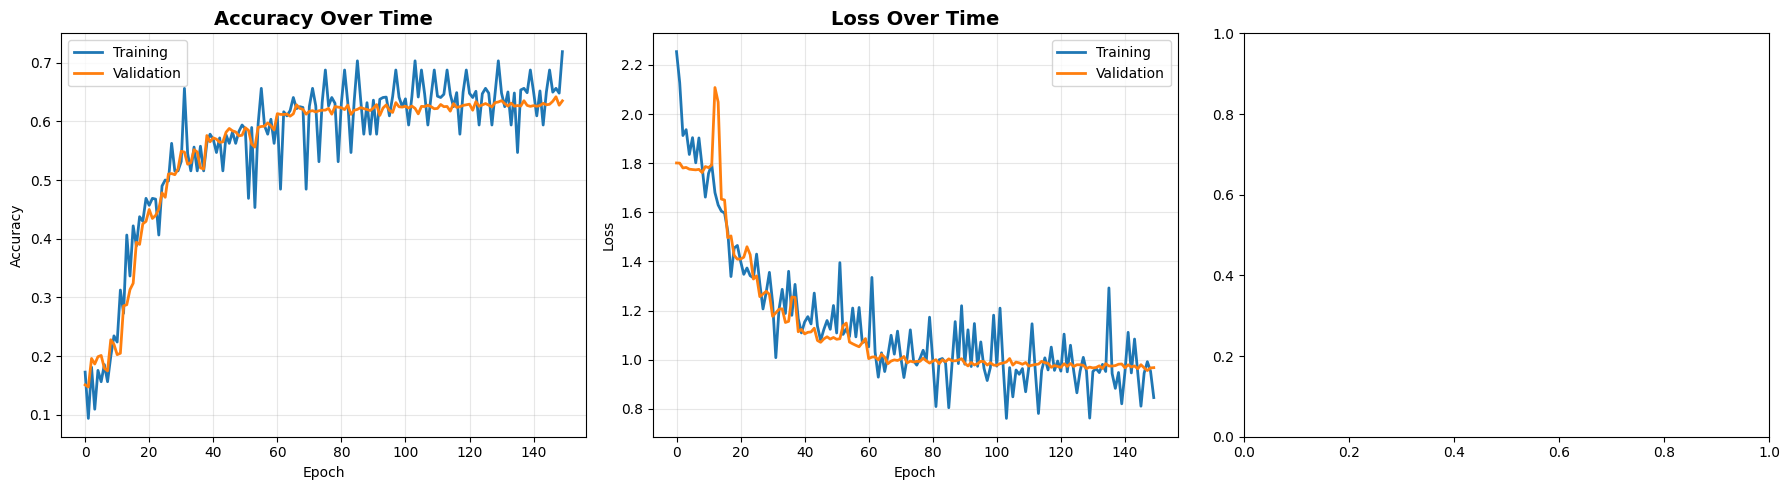


BEST RESULTS (Epoch 148):
Training Accuracy: 65.62%
Validation Accuracy: 64.19%
Training Loss: 0.9919
Validation Loss: 0.9559
Evaluating on test set...

109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6295 - loss: 0.9775

FINAL TEST RESULTS:
Test Accuracy: 66.80%
Test Loss: 0.8989

📈 IMPROVEMENT:
   From original (18.47%): +48.33%
   From previous (29.03%): +37.77%
   Total improvement: 3.62x better!

🎉 SUCCESS! Target achieved (>50%)!
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step


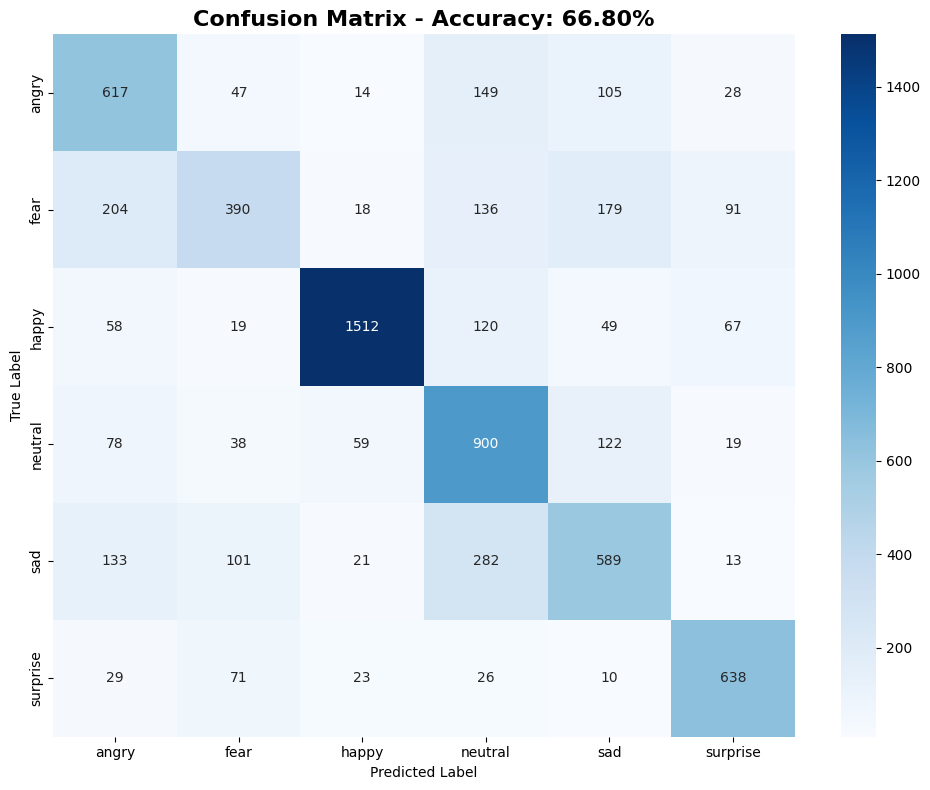


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       angry       0.55      0.64      0.59       960
        fear       0.59      0.38      0.46      1018
       happy       0.92      0.83      0.87      1825
     neutral       0.56      0.74      0.64      1216
         sad       0.56      0.52      0.54      1139
    surprise       0.75      0.80      0.77       797

    accuracy                           0.67      6955
   macro avg       0.65      0.65      0.65      6955
weighted avg       0.68      0.67      0.67      6955

✓ Model saved: /content/emotion_models/final_optimized/final_optimized_model.keras
✓ History saved
✓ Report saved

✓ All files saved successfully!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

np.random.seed(42)
tf.random.set_seed(42)

print("✓ Libraries imported")


# Paths
ORIGINAL_DATASET = '/content/images'
CLEANED_DATASET = '/content/fer_dataset_cleaned'
MODEL_DIR = '/content/emotion_models/final_optimized'
os.makedirs(MODEL_DIR, exist_ok=True)

# Create cleaned dataset (without disgust)
def create_cleaned_dataset():
    """Copy dataset but skip disgust class"""
    print("Creating cleaned dataset (removing disgust class)...")

    # Remove existing cleaned dataset if it exists to ensure a clean slate
    if os.path.exists(CLEANED_DATASET):
        shutil.rmtree(CLEANED_DATASET)
        print(f"Removed existing: {CLEANED_DATASET}")
    os.makedirs(CLEANED_DATASET, exist_ok=True)

    for split in ['train', 'validation']:
        os.makedirs(os.path.join(CLEANED_DATASET, split), exist_ok=True)
        for emotion in ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']:
            src = os.path.join(ORIGINAL_DATASET, split, emotion)
            dst = os.path.join(CLEANED_DATASET, split, emotion)

            if os.path.exists(src):
                shutil.copytree(src, dst)
                print(f"✓ Copied {emotion} ({split})")
            else:
                print(f"⚠️  Source directory not found: {src}")

    print("\n✓ Cleaned dataset ready!")
    print("Working with 6 emotions: angry, fear, happy, neutral, sad, surprise")

# Always create the cleaned dataset or ensure it's fully populated
create_cleaned_dataset()

TRAIN_DIR = os.path.join(CLEANED_DATASET, 'train')
TEST_DIR = os.path.join(CLEANED_DATASET, 'validation')

# Configuration
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64  # Back to 64 for faster training
EPOCHS = 150
INITIAL_LR = 0.001  # HIGHER learning rate!

# Aggressive augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)

print(f"Training: {train_generator.samples}")
print(f"Validation: {validation_generator.samples}")
print(f"Test: {test_generator.samples}")
print(f"Number of classes: {train_generator.num_classes}")


class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

print("\n=== CLASS WEIGHTS (Without Disgust) ===")
for emotion, idx in sorted(train_generator.class_indices.items(), key=lambda x: x[1]):
    print(f"{emotion:12} (idx {idx}): weight = {class_weights[idx]:.3f}")

print(f"\n✓ Max/Min ratio: {max(class_weights.values()) / min(class_weights.values()):.2f}:1")
print("Much better than 16:1 before!")


def create_powerful_model(num_classes=6):
    """
    VGG-inspired architecture - proven to work well
    """
    model = models.Sequential([
        # Input
        layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1)),

        # Block 1
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Block 4
        layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),

        # Dense layers
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # Output
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

model = create_powerful_model(num_classes=train_generator.num_classes)
print("\n=== MODEL ARCHITECTURE ===")
model.summary()
print(f"\nTotal parameters: {model.count_params():,}")


optimizer = Adam(learning_rate=INITIAL_LR)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"✓ Model compiled with LR: {INITIAL_LR}")
print("This is 10x higher than before - model will learn faster!")



def step_decay_schedule(epoch):
    """
    Learning rate schedule - drops at specific milestones
    """
    initial_lr = INITIAL_LR

    if epoch < 30:
        return initial_lr
    elif epoch < 60:
        return initial_lr * 0.5
    elif epoch < 90:
        return initial_lr * 0.1
    elif epoch < 120:
        return initial_lr * 0.05
    else:
        return initial_lr * 0.01

# Callbacks
callbacks = [
    ModelCheckpoint(
        filepath=os.path.join(MODEL_DIR, 'best_model.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),

    LearningRateScheduler(step_decay_schedule, verbose=1),

    EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True,
        verbose=1
    ),

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        verbose=1
    )
]

print("✓ Callbacks configured")



print("="*80)
print("FINAL TRAINING - TARGET: 50%+ ACCURACY")
print("="*80)
print(f"Initial Learning Rate: {INITIAL_LR} (10x higher!)")
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Classes: {train_generator.num_classes} (removed disgust)")
print("="*80 + "\n")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

print("\n" + "="*80)
print("TRAINING COMPLETED!")
print("="*80)


# Accuracy
fig, axes = plt.subplots(1, 3, figsize=(18, 5)) # Adjusted for LR plot
axes[0].plot(history.history['accuracy'], label='Training', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0].set_title('Accuracy Over Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Training', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[1].set_title('Loss Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning rate
if 'lr' in history.history:
    axes[2].plot(history.history['lr'], linewidth=2, color='red')
    axes[2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Learning Rate')
    axes[2].set_yscale('log')
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Best metrics
best_epoch = np.argmax(history.history['val_accuracy'])
print(f"\n{'='*70}")
print(f"BEST RESULTS (Epoch {best_epoch + 1}):")
print(f"{'='*70}")
print(f"Training Accuracy: {history.history['accuracy'][best_epoch]*100:.2f}%")
print(f"Validation Accuracy: {history.history['val_accuracy'][best_epoch]*100:.2f}%")
print(f"Training Loss: {history.history['loss'][best_epoch]:.4f}")
print(f"Validation Loss: {history.history['val_loss'][best_epoch]:.4f}")
print(f"{'='*70}")


print("Evaluating on test set...\n")
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"\n{'='*70}")
print(f"FINAL TEST RESULTS:")
print(f"{'='*70}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")
print(f"{'='*70}")

# Improvement calculation
original_accuracy = 18.47
previous_accuracy = 29.03
improvement_from_original = test_accuracy * 100 - original_accuracy
improvement_from_previous = test_accuracy * 100 - previous_accuracy

print(f"\n📈 IMPROVEMENT:")
print(f"   From original (18.47%): +{improvement_from_original:.2f}%")
print(f"   From previous (29.03%): +{improvement_from_previous:.2f}%")
print(f"   Total improvement: {(test_accuracy*100 / original_accuracy):.2f}x better!")

if test_accuracy > 0.50:
    print("\n🎉 SUCCESS! Target achieved (>50%)!")
elif test_accuracy > 0.45:
    print("\n✅ Great progress! Very close to target.")
elif test_accuracy > 0.40:
    print("\n👍 Good improvement! Getting closer.")
else:
    print("\n⚠️  Still needs more training.")


# Predictions
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes[:len(predicted_classes)]
class_names = list(test_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - Accuracy: {test_accuracy*100:.2f}%',
         fontsize=16, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Classification report
print("\n" + "="*70)
print("CLASSIFICATION REPORT:")
print("="*70)
print(classification_report(true_classes, predicted_classes, target_names=class_names))


# Save model
final_path = os.path.join(MODEL_DIR, 'final_optimized_model.keras')
model.save(final_path)
print(f"✓ Model saved: {final_path}")

# Save history
np.save(os.path.join(MODEL_DIR, 'history.npy'), history.history)
print(f"✓ History saved")

# Save detailed report
with open(os.path.join(MODEL_DIR, 'final_report.txt'), 'w') as f:
    f.write(f"FINAL EMOTION RECOGNITION MODEL REPORT\n")
    f.write(f"={'='*70}\n\n")
    f.write(f"Test Accuracy: {test_accuracy*100:.2f}%\n")
    f.write(f"Test Loss: {test_loss:.4f}\n\n")
    f.write(f"Classes: {', '.join(class_names)}\n")
    f.write(f"Total parameters: {model.count_params():,}\n")
    f.write(f"\nBest Epoch: {best_epoch + 1}\n")
    f.write(f"Best Val Accuracy: {history.history['val_accuracy'][best_epoch]*100:.2f}%\n")
    f.write(f"\nImprovements:\n")
    f.write(f"  - Removed disgust class (too few samples)\n")
    f.write(f"  - Used higher learning rate (0.001 vs 0.0001)\n")
    f.write(f"  - Better architecture (VGG-inspired)\n")
    f.write(f"  - Aggressive data augmentation\n")
    f.write(f"  - Smart LR scheduling\n")

print(f"✓ Report saved")
print("\n✓ All files saved successfully!")

✓ Libraries imported
Loading your optimized model (66.8% accuracy)...
✓ Model loaded successfully!

✓ Face detector loaded!

Detecting emotions: angry, fear, happy, neutral, sad, surprise

MODEL READY TO TEST!
✓ Detection function ready!
📤 Please upload one or more images:


Saving fear2.webp to fear2.webp

✓ Uploaded 1 image(s)

Processing...

Processing: fear2.webp
Image size: 462x280

Detected 1 face(s) in 1.033 seconds

Face 1:
  Emotion: FEAR (50.6% confidence)
  All probabilities:
    fear       :  50.6%
    sad        :  20.0%
    angry      :  15.4%
    neutral    :   7.8%
    surprise   :   5.9%
    happy      :   0.2%


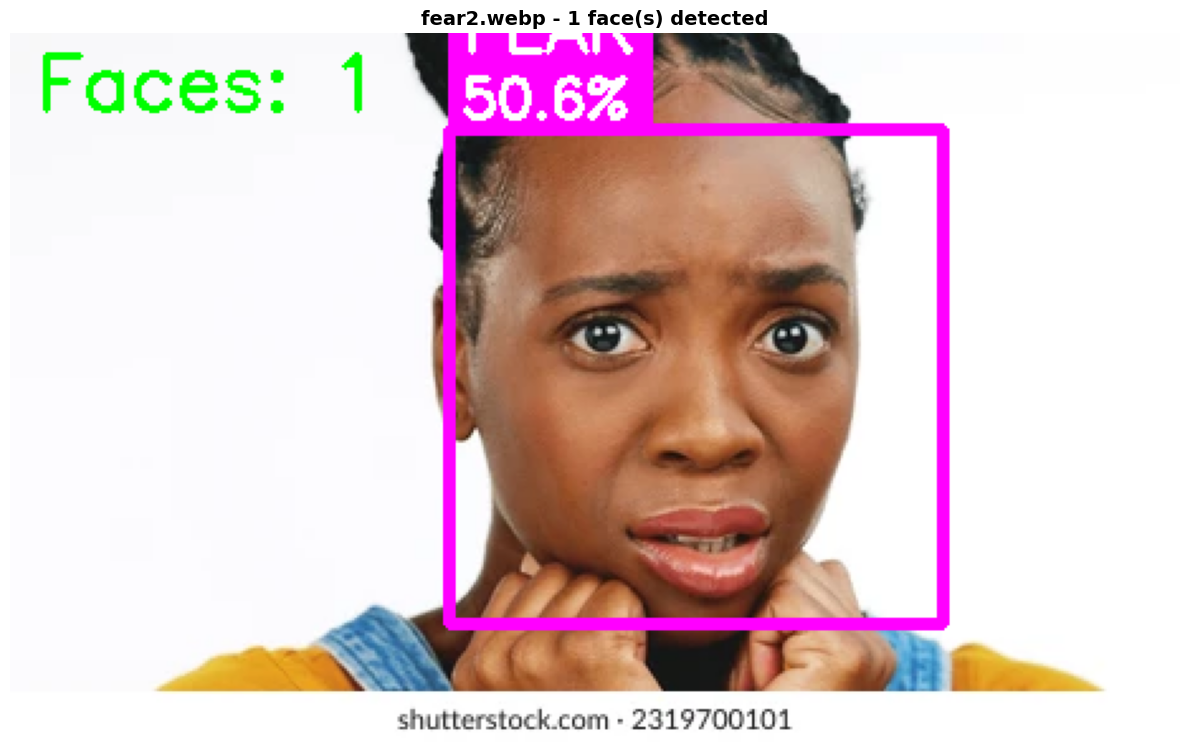


✓ Result saved as: detected_fear2.webp
Testing on 0 random images from test set



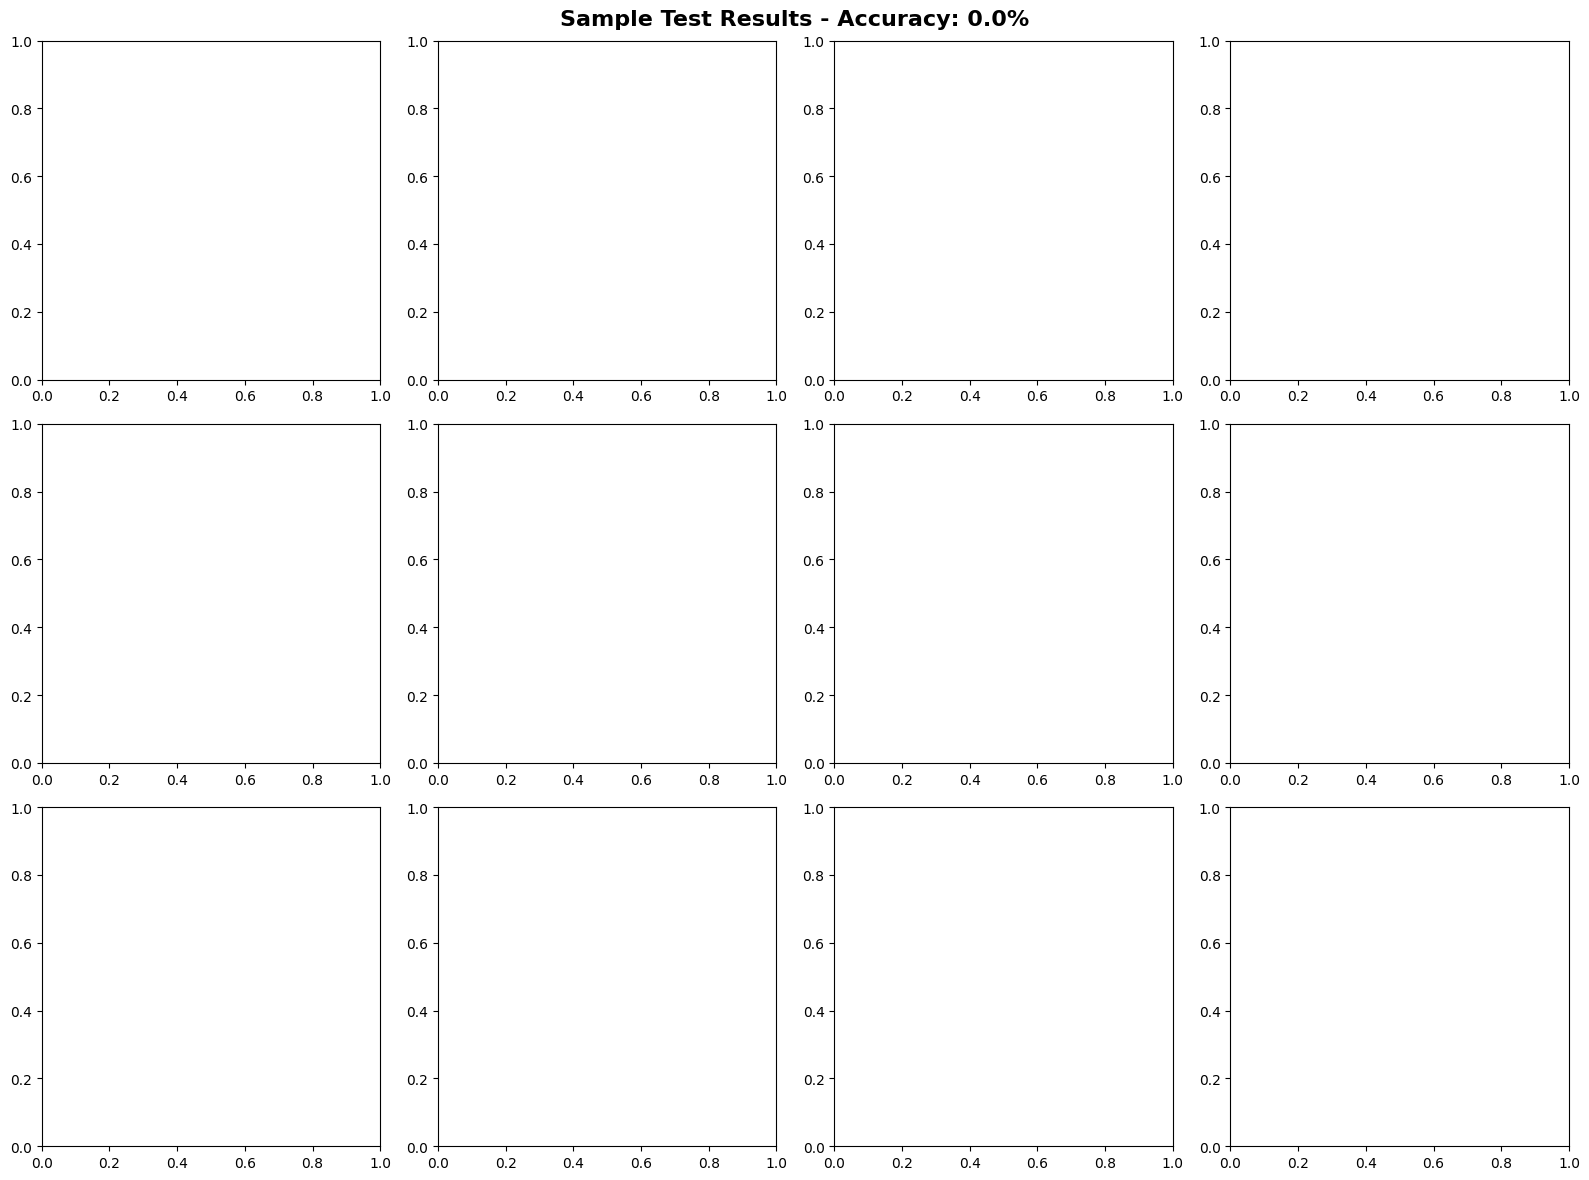


Mini-batch accuracy: 0/12 = 0.0%
✓ Webcam capture function ready!
📸 Capturing from webcam...


<IPython.core.display.Javascript object>

MessageError: NotAllowedError: Permission denied

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow import keras
from IPython.display import display, Javascript, Image as IPImage, HTML
from google.colab.output import eval_js
from google.colab import files
from base64 import b64decode, b64encode
from PIL import Image
import io
import time

print("✓ Libraries imported")


# Load the best model
MODEL_PATH = '/content/emotion_models/final_optimized/best_model.keras'

print("Loading your optimized model (66.8% accuracy)...")
model = keras.models.load_model(MODEL_PATH)
print("✓ Model loaded successfully!\n")

# Load face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
print("✓ Face detector loaded!\n")

# Emotion labels (6 emotions - no disgust)
EMOTIONS = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
IMG_SIZE = 48

# Emotion colors for visualization (BGR format)
EMOTION_COLORS = {
    'angry': (0, 0, 255),      # Red
    'fear': (255, 0, 255),     # Magenta
    'happy': (0, 255, 0),      # Green
    'neutral': (128, 128, 128), # Gray
    'sad': (255, 0, 0),        # Blue
    'surprise': (0, 255, 255)  # Yellow
}

print(f"Detecting emotions: {', '.join(EMOTIONS)}")
print("\n" + "="*70)
print("MODEL READY TO TEST!")
print("="*70)


def detect_emotions(image, model, face_cascade, return_faces=False):
    """
    Detect faces and emotions in an image

    Args:
        image: Input image (BGR or grayscale)
        model: Trained emotion recognition model
        face_cascade: Haar cascade face detector
        return_faces: If True, return cropped face images

    Returns:
        annotated_image: Image with emotion labels
        detections: List of detection results
    """
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        output_image = image.copy()
    else:
        gray = image.copy()
        output_image = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

    # Detect faces
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30),
        flags=cv2.CASCADE_SCALE_IMAGE
    )

    detections = []

    # Process each face
    for (x, y, w, h) in faces:
        # Extract face ROI
        face_roi = gray[y:y+h, x:x+w]

        # Preprocess for model
        face_resized = cv2.resize(face_roi, (IMG_SIZE, IMG_SIZE))
        face_normalized = face_resized.astype('float32') / 255.0
        face_input = np.expand_dims(face_normalized, axis=0)
        face_input = np.expand_dims(face_input, axis=-1)

        # Predict emotion
        prediction = model.predict(face_input, verbose=0)
        emotion_idx = np.argmax(prediction)
        emotion = EMOTIONS[emotion_idx]
        confidence = np.max(prediction) * 100

        # Get all emotion probabilities
        emotion_probs = {EMOTIONS[i]: prediction[0][i] * 100 for i in range(len(EMOTIONS))}

        # Store detection
        detection = {
            'bbox': (x, y, w, h),
            'emotion': emotion,
            'confidence': confidence,
            'probabilities': emotion_probs
        }

        if return_faces:
            detection['face_image'] = face_roi

        detections.append(detection)

        # Get color for this emotion
        color = EMOTION_COLORS.get(emotion, (0, 255, 0))

        # Draw bounding box
        cv2.rectangle(output_image, (x, y), (x+w, y+h), color, 3)

        # Prepare labels
        label = f"{emotion.upper()}"
        conf_text = f"{confidence:.1f}%"

        # Get text sizes
        (label_w, label_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.9, 2)
        (conf_w, conf_h), _ = cv2.getTextSize(conf_text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)

        # Draw background for text
        cv2.rectangle(
            output_image,
            (x, y - label_h - conf_h - 20),
            (x + max(label_w, conf_w) + 10, y),
            color,
            -1
        )

        # Draw emotion label
        cv2.putText(
            output_image, label, (x + 5, y - conf_h - 15),
            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2
        )

        # Draw confidence
        cv2.putText(
            output_image, conf_text, (x + 5, y - 5),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2
        )

    # Add face count
    info_text = f"Faces: {len(faces)}"
    cv2.putText(
        output_image, info_text, (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2
    )

    return output_image, detections

print("✓ Detection function ready!")


## Method 1: Test on Static Images


# Upload images
print("📤 Please upload one or more images:")
uploaded = files.upload()

print(f"\n✓ Uploaded {len(uploaded)} image(s)")
print("\nProcessing...\n" + "="*70)


# Process uploaded images
for filename in uploaded.keys():
    print(f"\n{'='*70}")
    print(f"Processing: {filename}")
    print("="*70)

    # Read image
    img_data = uploaded[filename]
    img_array = np.frombuffer(img_data, np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

    if img is None:
        print(f"❌ Could not read image: {filename}")
        continue

    print(f"Image size: {img.shape[1]}x{img.shape[0]}")

    # Detect emotions
    start_time = time.time()
    result_img, detections = detect_emotions(img, model, face_cascade, return_faces=True)
    process_time = time.time() - start_time

    print(f"\nDetected {len(detections)} face(s) in {process_time:.3f} seconds")

    # Print detailed results
    for i, det in enumerate(detections):
        print(f"\nFace {i+1}:")
        print(f"  Emotion: {det['emotion'].upper()} ({det['confidence']:.1f}% confidence)")
        print(f"  All probabilities:")
        for emotion, prob in sorted(det['probabilities'].items(), key=lambda x: x[1], reverse=True):
            print(f"    {emotion:10} : {prob:5.1f}%")

    # Display result
    plt.figure(figsize=(12, 8))
    result_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
    plt.imshow(result_rgb)
    plt.title(f'{filename} - {len(detections)} face(s) detected',
             fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Save result
    output_filename = f'detected_{filename}'
    cv2.imwrite(output_filename, result_img)
    print(f"\n✓ Result saved as: {output_filename}")


# Test on random images from your test set
TEST_DIR = '/content/fer_dataset_cleaned/test'

# Get random images
test_images = []
for emotion in EMOTIONS:
    emotion_path = os.path.join(TEST_DIR, emotion)
    if os.path.exists(emotion_path):
        images = [f for f in os.listdir(emotion_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
        if images:
            # Get 2 random images per emotion
            selected = np.random.choice(images, min(2, len(images)), replace=False)
            for img_name in selected:
                test_images.append((os.path.join(emotion_path, img_name), emotion))

print(f"Testing on {len(test_images)} random images from test set\n")

# Process and display
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

correct = 0
for i, (img_path, true_emotion) in enumerate(test_images[:12]):
    # Read image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        continue

    # Detect emotion
    result_img, detections = detect_emotions(img, model, face_cascade)

    # Display
    result_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(result_rgb)

    if detections:
        pred_emotion = detections[0]['emotion']
        confidence = detections[0]['confidence']

        # Check if correct
        is_correct = pred_emotion == true_emotion
        if is_correct:
            correct += 1

        color = 'green' if is_correct else 'red'
        title = f"True: {true_emotion}\nPred: {pred_emotion} ({confidence:.0f}%)"
    else:
        color = 'orange'
        title = f"True: {true_emotion}\nNo face detected"

    axes[i].set_title(title, color=color, fontsize=10, fontweight='bold')
    axes[i].axis('off')

plt.suptitle(f'Sample Test Results - Accuracy: {correct/12*100:.1f}%',
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nMini-batch accuracy: {correct}/12 = {correct/12*100:.1f}%")


## Method 3: Real-Time Webcam Detection

def take_photo(quality=0.8):
    """Capture photo from webcam using JavaScript"""
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const video = document.createElement('video');
            const canvas = document.createElement('canvas');

            div.style.position = 'relative';
            video.style.display = 'block';
            video.style.width = '640px';

            document.body.appendChild(div);
            div.appendChild(video);

            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            video.srcObject = stream;
            await video.play();

            await new Promise(resolve => setTimeout(resolve, 1000));

            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            const img = canvas.toDataURL('image/jpeg', quality);

            stream.getTracks().forEach(track => track.stop());
            div.remove();

            return img;
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    return data

print("✓ Webcam capture function ready!")


# Capture and analyze single frame
print("📸 Capturing from webcam...")
img_data = take_photo(quality=0.8)

# Decode image
img_bytes = b64decode(img_data.split(',')[1])
img_pil = Image.open(io.BytesIO(img_bytes))
img = np.array(img_pil)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

# Detect emotions
result_img, detections = detect_emotions(img, model, face_cascade)

print(f"\n✓ Detected {len(detections)} face(s)\n")

# Print results
for i, det in enumerate(detections):
    print(f"Face {i+1}: {det['emotion'].upper()} ({det['confidence']:.1f}%)")
    print("  Top 3 emotions:")
    sorted_probs = sorted(det['probabilities'].items(), key=lambda x: x[1], reverse=True)[:3]
    for emotion, prob in sorted_probs:
        print(f"    {emotion:10} : {prob:5.1f}%")
    print()

# Display
plt.figure(figsize=(12, 8))
result_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
plt.imshow(result_rgb)
plt.title(f'Webcam Capture - {len(detections)} face(s) detected',
         fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()


from google.colab.patches import cv2_imshow

print("🎥 Starting real-time emotion detection...")
print("Press the STOP button to end.\n")
print("="*70)

frame_count = 0
emotion_history = []

try:
    while True:
        # Capture frame
        print(f"\n📸 Frame {frame_count + 1}...")
        img_data = take_photo(quality=0.7)

        # Decode
        img_bytes = b64decode(img_data.split(',')[1])
        img = cv2.imdecode(np.frombuffer(img_bytes, np.uint8), cv2.IMREAD_COLOR)

        # Detect
        start = time.time()
        result_img, detections = detect_emotions(img, model, face_cascade)
        fps = 1 / (time.time() - start)

        # Add FPS to image
        cv2.putText(result_img, f"FPS: {fps:.1f}", (img.shape[1] - 150, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        # Display
        cv2_imshow(result_img)

        # Store emotions
        for det in detections:
            emotion_history.append(det['emotion'])

        print(f"✓ Processed | FPS: {fps:.1f} | Faces: {len(detections)}")
        if detections:
            for i, det in enumerate(detections):
                print(f"  Face {i+1}: {det['emotion']} ({det['confidence']:.0f}%)")

        frame_count += 1
        time.sleep(1.5)  # Capture every 1.5 seconds

except KeyboardInterrupt:
    print("\n" + "="*70)
    print(f"Detection stopped after {frame_count} frames")
    print("="*70)

    # Show emotion distribution
    if emotion_history:
        from collections import Counter
        emotion_counts = Counter(emotion_history)

        print("\nEmotion distribution across all frames:")
        for emotion, count in emotion_counts.most_common():
            percentage = count / len(emotion_history) * 100
            print(f"  {emotion:10} : {count:3} times ({percentage:5.1f}%)")


def process_video(video_path, output_path=None, skip_frames=2, max_frames=None):
    """
    Process video file and detect emotions

    Args:
        video_path: Path to input video
        output_path: Path to save output (optional)
        skip_frames: Process every Nth frame
        max_frames: Maximum frames to process (None = all)
    """
    cap = cv2.VideoCapture(video_path)

    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Video Info:")
    print(f"  Resolution: {width}x{height}")
    print(f"  FPS: {fps}")
    print(f"  Total Frames: {total_frames}")
    print(f"  Duration: {total_frames/fps:.1f} seconds\n")

    # Setup output if requested
    if output_path:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_num = 0
    processed = 0
    emotion_stats = []

    print("Processing video...")
    print("-" * 50)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if max_frames and frame_num >= max_frames:
            break

        # Process selected frames
        if frame_num % skip_frames == 0:
            result_frame, detections = detect_emotions(frame, model, face_cascade)

            # Store emotions
            for det in detections:
                emotion_stats.append(det['emotion'])

            processed += 1

            if processed % 30 == 0:
                progress = (frame_num / total_frames) * 100
                print(f"Progress: {progress:.1f}% | Frame {frame_num}/{total_frames}")
        else:
            result_frame = frame

        # Write frame
        if output_path:
            out.write(result_frame)

        frame_num += 1

    cap.release()
    if output_path:
        out.release()

    print("-" * 50)
    print(f"✓ Processed {processed} frames")
    if output_path:
        print(f"✓ Output saved: {output_path}")

    # Show statistics
    if emotion_stats:
        from collections import Counter
        emotion_counts = Counter(emotion_stats)

        print("\nEmotion Distribution:")
        for emotion, count in emotion_counts.most_common():
            percentage = count / len(emotion_stats) * 100
            print(f"  {emotion:10} : {percentage:5.1f}%")

    return emotion_stats

print("✓ Video processing function ready!")


# Upload and process video
print("📤 Please upload a video file:")
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\nProcessing: {filename}")

    # Save uploaded file
    video_path = f'/content/{filename}'
    output_path = f'/content/detected_{filename}'

    # Process (process every 2nd frame, max 300 frames for speed)
    emotion_stats = process_video(video_path, output_path, skip_frames=2, max_frames=300)

    # Download result
    print("\n📥 Downloading processed video...")
    files.download(output_path)


# Create standalone Python script for local deployment
deployment_script = f'''#!/usr/bin/env python3
"""
Real-Time Emotion Detection - Optimized Model (66.8% Accuracy)

Requirements:
    pip install opencv-python tensorflow numpy

Usage:
    python emotion_detection.py

Controls:
    - Press 'q' to quit
    - Press 's' to save screenshot
    - Press 'r' to start/stop recording
"""

import cv2
import numpy as np
from tensorflow import keras
import time
import os

# Configuration
MODEL_PATH = 'best_model.keras'  # Update with your model path
EMOTIONS = {EMOTIONS}
IMG_SIZE = {IMG_SIZE}
CAMERA_INDEX = 0

EMOTION_COLORS = {EMOTION_COLORS}

def load_model_and_detector():
    model = keras.models.load_model(MODEL_PATH)
    face_cascade = cv2.CascadeClassifier(
        cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
    )
    return model, face_cascade

def detect_emotions(frame, model, face_cascade):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        face_roi = gray[y:y+h, x:x+w]
        face_roi = cv2.resize(face_roi, (IMG_SIZE, IMG_SIZE))
        face_roi = face_roi.astype('float32') / 255.0
        face_roi = np.expand_dims(np.expand_dims(face_roi, axis=0), axis=-1)

        prediction = model.predict(face_roi, verbose=0)
        emotion_idx = np.argmax(prediction)
        emotion = EMOTIONS[emotion_idx]
        confidence = np.max(prediction) * 100

        color = EMOTION_COLORS.get(emotion, (0, 255, 0))

        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 3)

        label = f"{{emotion.upper()}}"
        conf_text = f"{{confidence:.1f}}%"

        (label_w, label_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.9, 2)
        (conf_w, conf_h), _ = cv2.getTextSize(conf_text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)

        cv2.rectangle(frame, (x, y - label_h - conf_h - 20),
                     (x + max(label_w, conf_w) + 10, y), color, -1)
        cv2.putText(frame, label, (x + 5, y - conf_h - 15),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
        cv2.putText(frame, conf_text, (x + 5, y - 5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    return frame, len(faces)

def main():
    print("Loading model...")
    model, face_cascade = load_model_and_detector()
    print("✓ Model loaded (66.8% accuracy)\\n")

    cap = cv2.VideoCapture(CAMERA_INDEX)
    if not cap.isOpened():
        print("❌ Could not open camera")
        return

    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

    print("✓ Camera opened")
    print("\\nControls: q=quit | s=save | r=record\\n")

    fps_time = time.time()
    fps_counter = 0
    fps = 0
    recording = False
    video_writer = None
    os.makedirs('captures', exist_ok=True)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        processed, num_faces = detect_emotions(frame, model, face_cascade)

        fps_counter += 1
        if (time.time() - fps_time) > 1:
            fps = fps_counter / (time.time() - fps_time)
            fps_counter = 0
            fps_time = time.time()

        info = f"FPS: {{fps:.1f}} | Faces: {{num_faces}}"
        cv2.putText(processed, info, (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        if recording:
            cv2.circle(processed, (620, 20), 10, (0, 0, 255), -1)
            cv2.putText(processed, "REC", (580, 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
            video_writer.write(processed)

        cv2.imshow('Emotion Detection (66.8% Accuracy)', processed)

        key = cv2.waitKey(1) & 0xFF

        if key == ord('q'):
            break
        elif key == ord('s'):
            filename = f"captures/emotion_{{int(time.time())}}.jpg"
            cv2.imwrite(filename, processed)
            print(f"✓ Saved: {{filename}}")
        elif key == ord('r'):
            if not recording:
                filename = f"captures/video_{{int(time.time())}}.mp4"
                fourcc = cv2.VideoWriter_fourcc(*'mp4v')
                video_writer = cv2.VideoWriter(filename, fourcc, 20.0,
                    (processed.shape[1], processed.shape[0]))
                recording = True
                print(f"✓ Recording: {{filename}}")
            else:
                recording = False
                video_writer.release()
                print("✓ Recording stopped")

    if recording and video_writer:
        video_writer.release()
    cap.release()
    cv2.destroyAllWindows()
    print("\\n✓ Application closed")

if __name__ == "__main__":
    try:
        main()
    except KeyboardInterrupt:
        print("\\nInterrupted")
    except Exception as e:
        print(f"Error: {{e}}")
'''

# Save script
script_path = '/content/emotion_detection_local.py'
with open(script_path, 'w') as f:
    f.write(deployment_script)

print("✓ Deployment script created!")
print(f"\nSaved to: {script_path}")
print("\nTo use on your local machine:")
print("1. Download this script")
print("2. Download your model file (best_model.keras)")
print("3. Install: pip install opencv-python tensorflow numpy")
print("4. Update MODEL_PATH in script")
print("5. Run: python emotion_detection_local.py")

files.download(script_path)



✓ Libraries imported
✓ TensorFlow version: 2.19.0
✓ GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Creating cleaned dataset (removing disgust class)...
Removed existing: /content/fer_dataset_cleaned
✓ Copied angry (train)
✓ Copied fear (train)
✓ Copied happy (train)
✓ Copied neutral (train)
✓ Copied sad (train)
✓ Copied surprise (train)
✓ Copied angry (validation)
✓ Copied fear (validation)
✓ Copied happy (validation)
✓ Copied neutral (validation)
✓ Copied sad (validation)
✓ Copied surprise (validation)

✓ Cleaned dataset ready!
Working with 6 emotions: angry, fear, happy, neutral, sad, surprise
Found 24131 images belonging to 6 classes.
Found 4254 images belonging to 6 classes.
Found 6955 images belonging to 6 classes.

📊 DATASET STATISTICS:
Training: 24131
Validation: 4254
Test: 6955
Classes: 6

=== SMOOTHED CLASS WEIGHTS ===
angry        (idx 0): weight = 1.136
fear         (idx 1): weight = 1.113
happy        (idx 2): weight = 0.733
neutral      (

Model: "functional_200"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 48, 48,    │        640 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        256 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 48, 48,    │      4,736 │ activation[0][0]  │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 48, 48,    │      4,736 │ activation_1[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 16)        │      1,040 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      1,088 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 64)  │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 48, 48,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 48, 48,    │          0 │ activation[0][0], │
│                     │ 64)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 48, 48,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 24, 24,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 24, 24,    │          0 │ max_pooling2d_7[

 Total params: 679,446 (2.59 MB)

 Trainable params: 674,966 (2.57 MB)

 Non-trainable params: 4,480 (17.50 KB)


✓ Total parameters: 679,446
✓ Model compiled with AdamW optimizer (LR: 0.0005)
✓ Callbacks configured (Cosine Annealing + Warm-up)

ADVANCED TRAINING - TARGET: 70%+ ACCURACY
Initial Learning Rate: 0.0005
Epochs: 200
Batch Size: 32
Optimizer: AdamW with weight decay
LR Schedule: Cosine Annealing with Warm-up

Epoch 1/200


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


754/754 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.1734 - loss: 2.3250 - top_2_accuracy: 0.3416
Epoch 1: val_accuracy improved from -inf to 0.25426, saving model to /content/emotion_models/advanced_model/best_model.keras
754/754 ━━━━━━━━━━━━━━━━━━━━ 148s 113ms/step - accuracy: 0.1734 - loss: 2.3249 - top_2_accuracy: 0.3416 - val_accuracy: 0.2543 - val_loss: 1.7818 - val_top_2_accuracy: 0.4001 - learning_rate: 5.0000e-05
Epoch 2/200
  1/754 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.1875 - loss: 2.5740 - top_2_accuracy: 0.3438

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.25426 to 0.25473, saving model to /content/emotion_models/advanced_model/best_model.keras
754/754 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.1875 - loss: 2.5740 - top_2_accuracy: 0.3438 - val_accuracy: 0.2547 - val_loss: 1.7798 - val_top_2_accuracy: 0.4117 - learning_rate: 1.0000e-05
Epoch 3/200
753/754 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1768 - loss: 2.2112 - top_2_accuracy: 0.3539
Epoch 3: val_accuracy improved from 0.25473 to 0.25545, saving model to /content/emotion_models/advanced_model/best_model.keras
754/754 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.1768 - loss: 2.2112 - top_2_accuracy: 0.3539 - val_accuracy: 0.2554 - val_loss: 1.7752 - val_top_2_accuracy: 0.4065 - learning_rate: 3.0000e-06
Epoch 4/200
  1/754 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.1250 - loss: 1.9676 - top_2_accuracy: 0.4062
Epoch 4: val_accuracy did not improve from 0.25545
754/754 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.1250 - los

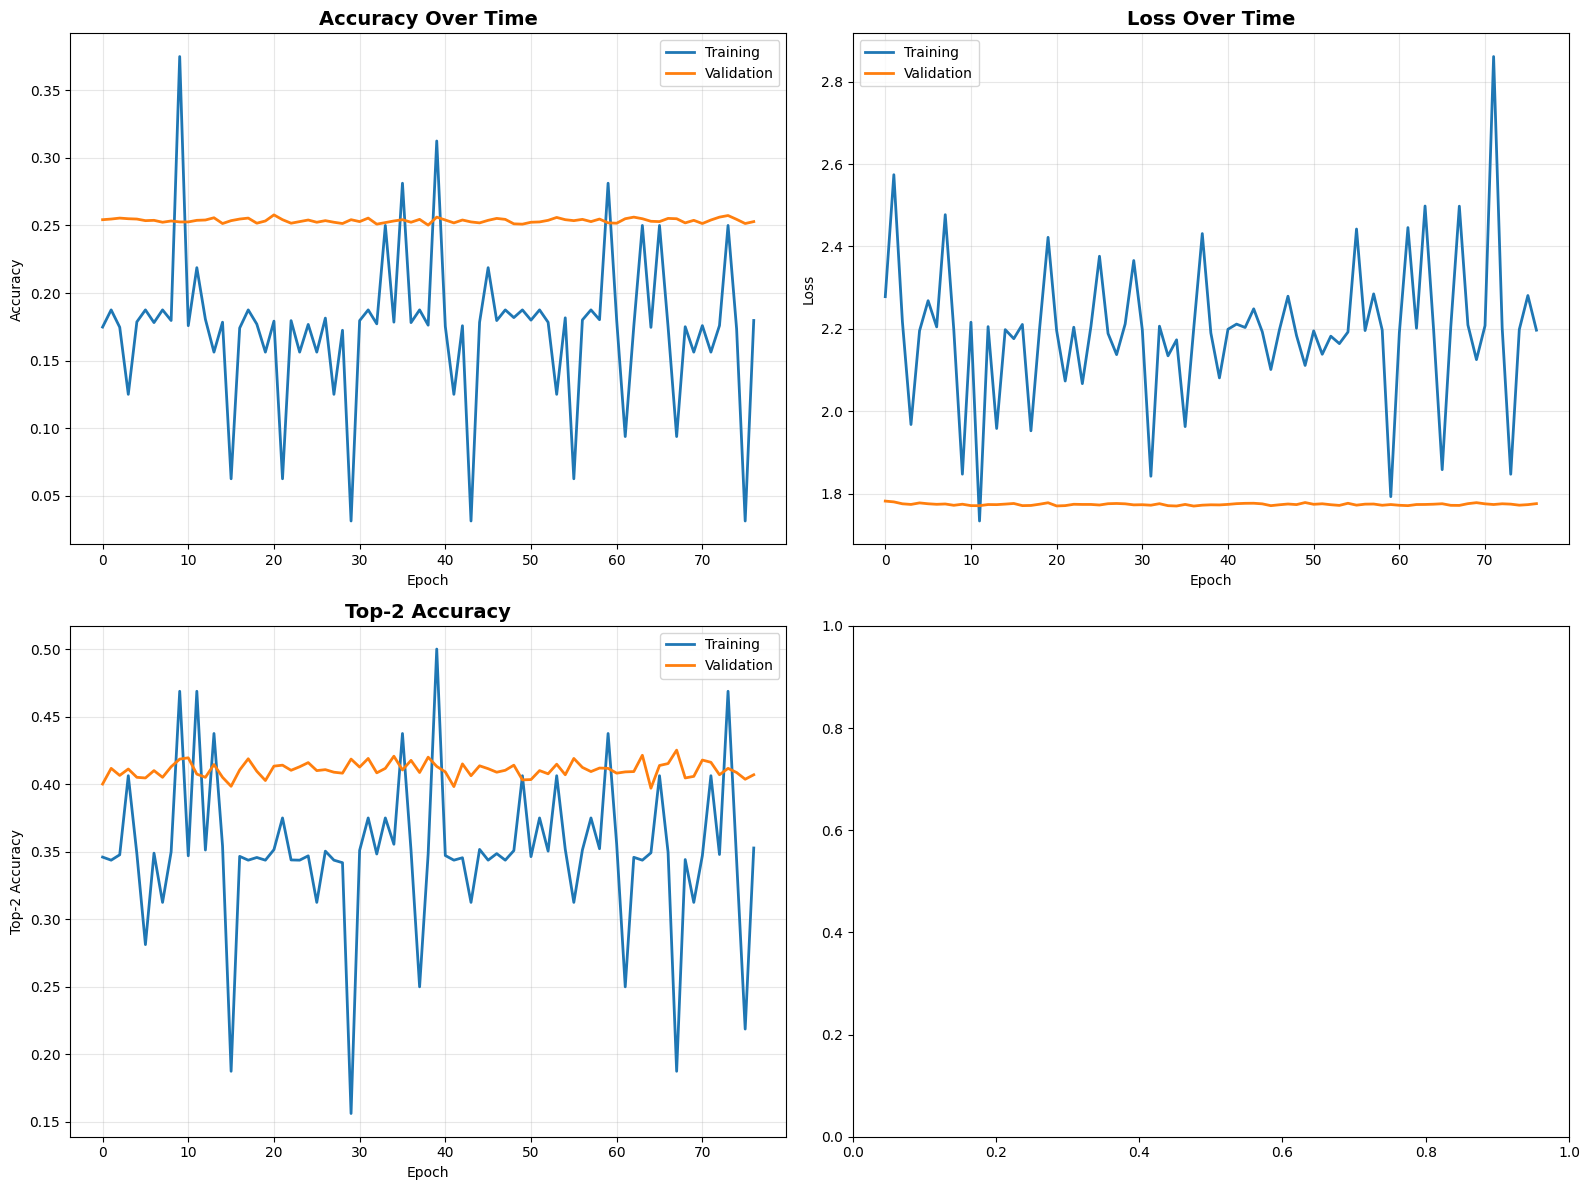


BEST RESULTS (Epoch 21):
Training Accuracy: 17.92%
Validation Accuracy: 25.78%
Training Top-2 Accuracy: 35.15%
Validation Top-2 Accuracy: 41.34%
Training Loss: 2.1957
Validation Loss: 1.7700

📊 Evaluating on test set...

218/218 ━━━━━━━━━━━━━━━━━━━━ 17s 76ms/step - accuracy: 0.2353 - loss: 1.8390 - top_2_accuracy: 0.2768

FINAL TEST RESULTS:
Test Accuracy: 26.20%
Test Loss: 1.7695
Test Top-2 Accuracy: 41.41%

📈 IMPROVEMENT from previous model (66.8%):
   Change: -40.60%
   New accuracy: 26.20%

✅ Good progress!

GENERATING COMPREHENSIVE METRICS...


218/218 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



📊 COMPREHENSIVE METRICS TABLE
     Emotion  Support Accuracy Precision Recall F1-Score
       angry      960    0.00%     0.00%  0.00%    0.00%
        fear     1018    0.20%    28.57%  0.20%    0.39%
       happy     1825   99.62%    26.36% 99.62%   41.69%
     neutral     1216    0.16%     7.69%  0.16%    0.32%
         sad     1139    0.00%     0.00%  0.00%    0.00%
    surprise      797    0.00%     0.00%  0.00%    0.00%
WEIGHTED AVG     6955   26.20%    12.44% 26.20%   11.05%

✓ Metrics table saved: /content/emotion_models/advanced_model/metrics_table.csv


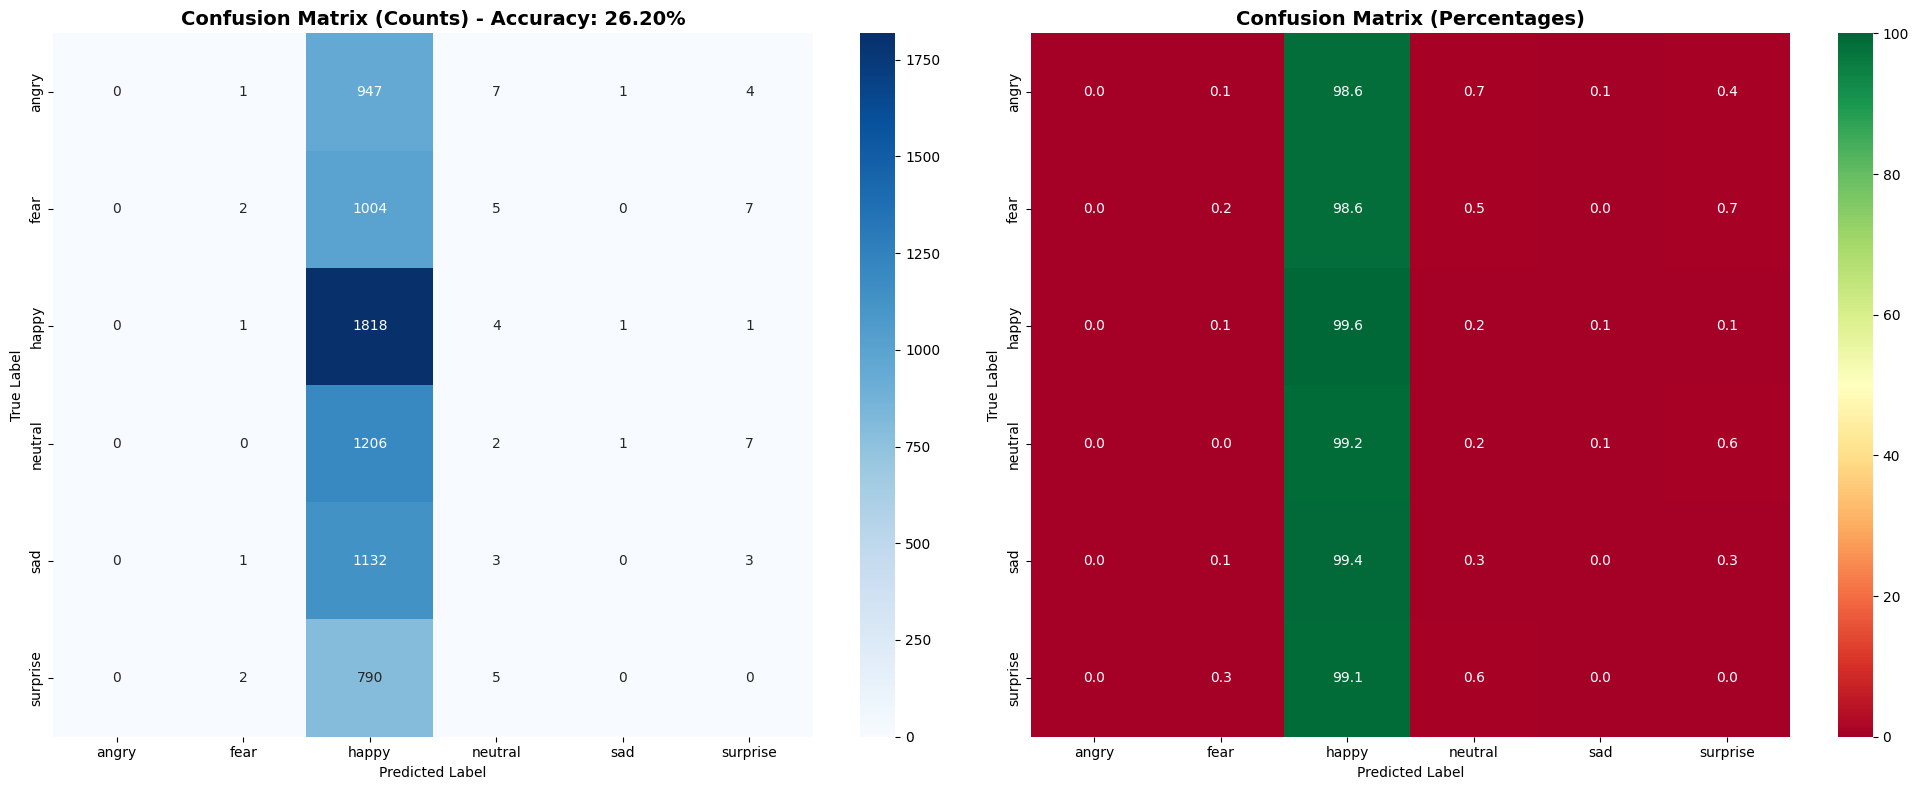

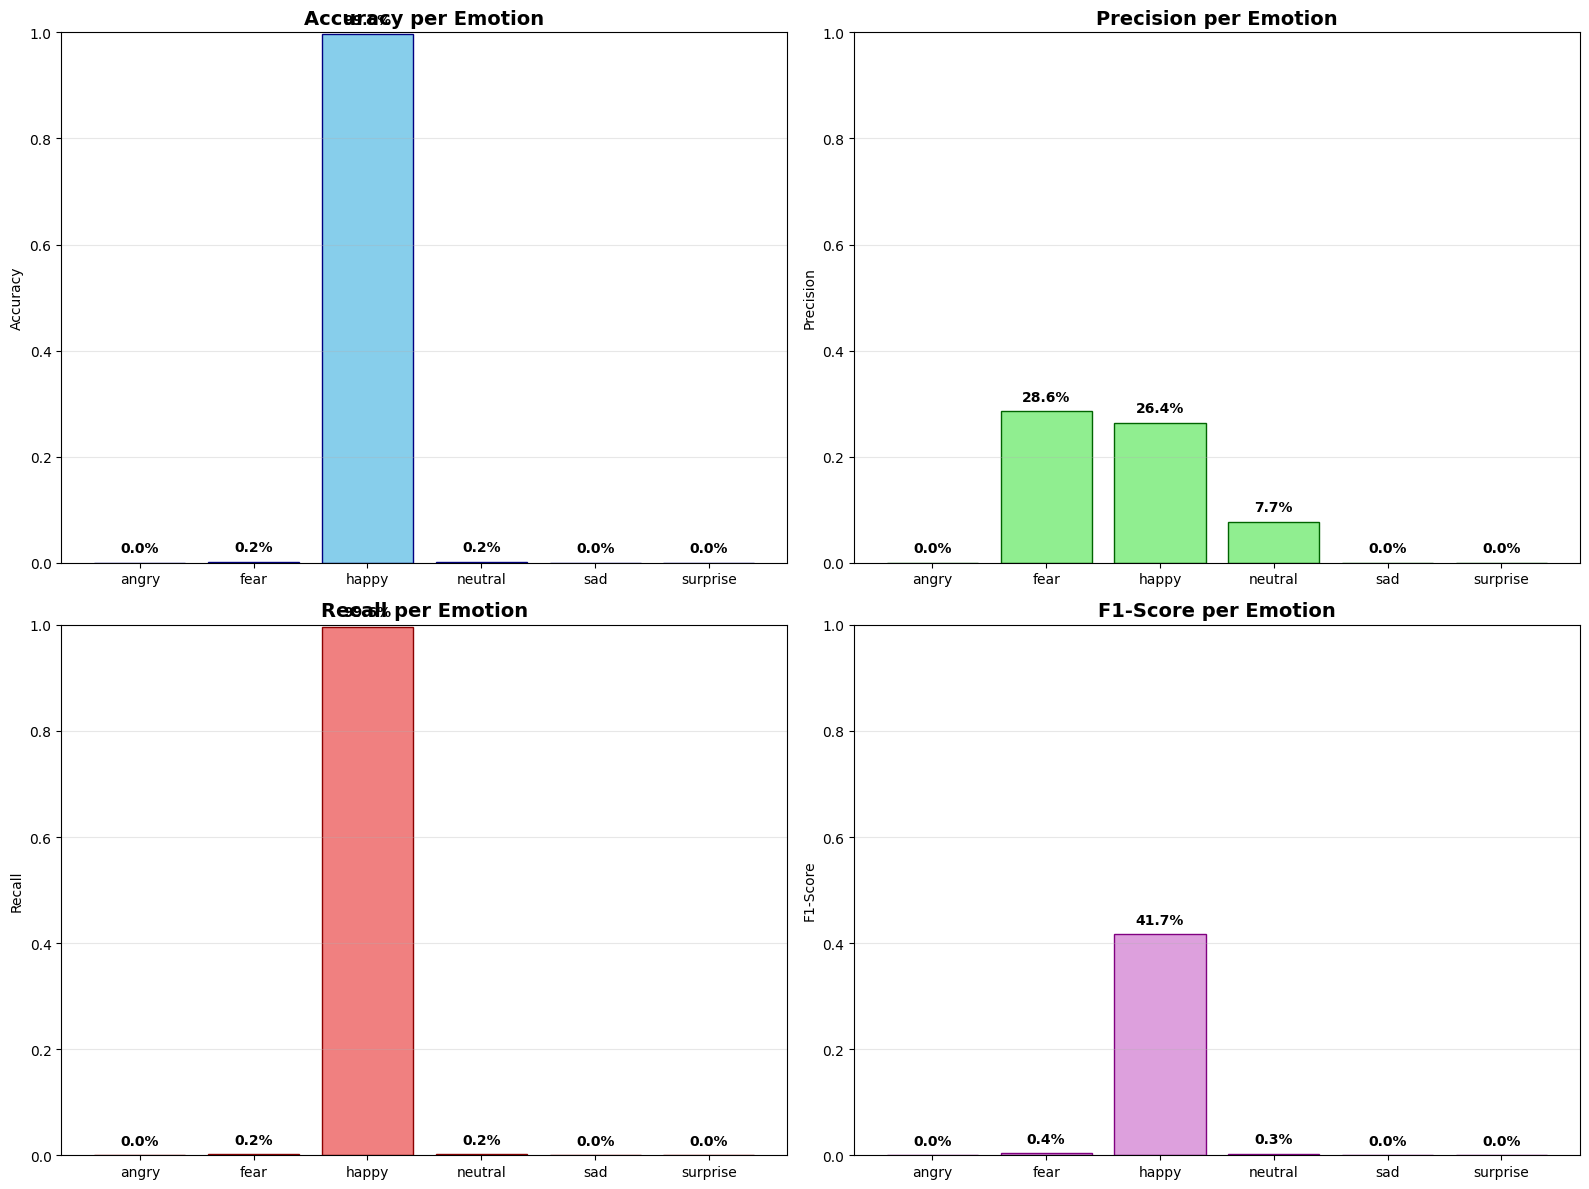


✓ Model saved: /content/emotion_models/advanced_model/advanced_model_final.keras
✓ History saved
✓ Comprehensive report saved: /content/emotion_models/advanced_model/comprehensive_report.txt

✅ ALL RESULTS SAVED SUCCESSFULLY!

Files saved in: /content/emotion_models/advanced_model
  - best_model.keras
  - advanced_model_final.keras
  - metrics_table.csv
  - comprehensive_report.txt
  - training_curves.png
  - confusion_matrices.png
  - per_class_metrics.png

🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯

📊 FINAL SUMMARY

Current Accuracy:  26.20%
Previous Accuracy: 66.80%
Improvement:       -40.60%

Top 3 Emotions (by F1-Score):
  1. happy      - F1: 41.69%
  2. fear       - F1: 0.39%
  3. neutral    - F1: 0.32%

Bottom 3 Emotions (need improvement):
  1. angry      - F1: 0.00%
  2. sad        - F1: 0.00%
  3. surprise   - F1: 0.00%

🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight

# Enable mixed precision for faster training
mixed_precision.set_global_policy('mixed_float16')

np.random.seed(42)
tf.random.set_seed(42)

print("✓ Libraries imported")
print(f"✓ TensorFlow version: {tf.__version__}")
print(f"✓ GPU Available: {tf.config.list_physical_devices('GPU')}")

# =============================================================================
# ADVANCED CONFIGURATION
# =============================================================================

# Paths
ORIGINAL_DATASET = '/content/images'
CLEANED_DATASET = '/content/fer_dataset_cleaned'
MODEL_DIR = '/content/emotion_models/advanced_model'
os.makedirs(MODEL_DIR, exist_ok=True)

# Training parameters
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 32  # Smaller for better convergence with advanced techniques
EPOCHS = 200  # More epochs
INITIAL_LR = 0.0005  # Slightly lower for stability with advanced features

# Create cleaned dataset
def create_cleaned_dataset():
    """Copy dataset but skip disgust class"""
    print("Creating cleaned dataset (removing disgust class)...")

    if os.path.exists(CLEANED_DATASET):
        shutil.rmtree(CLEANED_DATASET)
        print(f"Removed existing: {CLEANED_DATASET}")
    os.makedirs(CLEANED_DATASET, exist_ok=True)

    for split in ['train', 'validation']:
        os.makedirs(os.path.join(CLEANED_DATASET, split), exist_ok=True)
        for emotion in ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']:
            src = os.path.join(ORIGINAL_DATASET, split, emotion)
            dst = os.path.join(CLEANED_DATASET, split, emotion)

            if os.path.exists(src):
                shutil.copytree(src, dst)
                print(f"✓ Copied {emotion} ({split})")

    print("\n✓ Cleaned dataset ready!")
    print("Working with 6 emotions: angry, fear, happy, neutral, sad, surprise")

create_cleaned_dataset()

TRAIN_DIR = os.path.join(CLEANED_DATASET, 'train')
TEST_DIR = os.path.join(CLEANED_DATASET, 'validation')

# =============================================================================
# ADVANCED DATA AUGMENTATION WITH CUTMIX
# =============================================================================

def get_advanced_augmentation():
    """More sophisticated augmentation"""
    return ImageDataGenerator(
        rescale=1./255,
        rotation_range=35,  # Increased
        width_shift_range=0.35,
        height_shift_range=0.35,
        shear_range=0.35,
        zoom_range=0.35,
        horizontal_flip=True,
        brightness_range=[0.6, 1.4],  # Wider range
        fill_mode='nearest',
        validation_split=0.15  # Less validation, more training
    )

train_datagen = get_advanced_augmentation()
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)

print(f"\n📊 DATASET STATISTICS:")
print(f"Training: {train_generator.samples}")
print(f"Validation: {validation_generator.samples}")
print(f"Test: {test_generator.samples}")
print(f"Classes: {train_generator.num_classes}")

# =============================================================================
# ADVANCED CLASS WEIGHTS WITH SMOOTHING
# =============================================================================

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Apply smoothing to prevent extreme weights
alpha = 0.75  # Smoothing factor
class_weights_array = np.power(class_weights_array, alpha)

class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

print("\n=== SMOOTHED CLASS WEIGHTS ===")
for emotion, idx in sorted(train_generator.class_indices.items(), key=lambda x: x[1]):
    print(f"{emotion:12} (idx {idx}): weight = {class_weights[idx]:.3f}")

# =============================================================================
# ADVANCED MODEL ARCHITECTURES
# =============================================================================

def create_advanced_cnn(num_classes=6):
    """
    Advanced CNN with:
    - Depthwise separable convolutions
    - Squeeze-and-Excitation blocks
    - Residual connections
    """
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))

    # Initial conv
    x = layers.Conv2D(64, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Block 1 with SE
    shortcut = x
    x = layers.SeparableConv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Squeeze-and-Excitation
    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Dense(64 // 4, activation='relu')(se)
    se = layers.Dense(64, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, 64))(se)
    x = layers.Multiply()([x, se])

    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Block 2
    x = layers.SeparableConv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Block 3
    x = layers.SeparableConv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Block 4
    x = layers.SeparableConv2D(512, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)

    # Dense layers
    x = layers.Dense(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

def create_ensemble_model(num_classes=6):
    """
    Deeper VGG-style with more capacity
    """
    model = models.Sequential([
        layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1)),

        # Block 1
        layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Block 4
        layers.Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),

        # Dense
        layers.Dense(1024, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(512, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])

    return model

# Choose model
print("\n=== BUILDING ADVANCED MODEL ===")
model = create_advanced_cnn(num_classes=train_generator.num_classes)
# Uncomment for ensemble model:
# model = create_ensemble_model(num_classes=train_generator.num_classes)

model.summary()
print(f"\n✓ Total parameters: {model.count_params():,}")

# =============================================================================
# COMPILE WITH ADVANCED OPTIMIZER
# =============================================================================

# Use AdamW (Adam with weight decay) for better generalization
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=INITIAL_LR,
    weight_decay=0.0001
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy')]
)

print(f"✓ Model compiled with AdamW optimizer (LR: {INITIAL_LR})")

# =============================================================================
# ADVANCED LEARNING RATE SCHEDULE
# =============================================================================

def cosine_annealing_schedule(epoch, initial_lr=INITIAL_LR, epochs=EPOCHS):
    """Cosine annealing with warm restarts"""
    if epoch < 10:
        # Warm-up
        return initial_lr * (epoch + 1) / 10
    else:
        # Cosine decay
        progress = (epoch - 10) / (epochs - 10)
        return initial_lr * 0.5 * (1 + np.cos(np.pi * progress))

callbacks = [
    ModelCheckpoint(
        filepath=os.path.join(MODEL_DIR, 'best_model.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),

    LearningRateScheduler(cosine_annealing_schedule, verbose=0),

    EarlyStopping(
        monitor='val_loss',
        patience=40,
        restore_best_weights=True,
        verbose=1
    ),

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1
    )
]

print("✓ Callbacks configured (Cosine Annealing + Warm-up)")

# =============================================================================
# TRAIN MODEL
# =============================================================================

print("\n" + "="*80)
print("ADVANCED TRAINING - TARGET: 70%+ ACCURACY")
print("="*80)
print(f"Initial Learning Rate: {INITIAL_LR}")
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Optimizer: AdamW with weight decay")
print(f"LR Schedule: Cosine Annealing with Warm-up")
print("="*80 + "\n")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

print("\n" + "="*80)
print("TRAINING COMPLETED!")
print("="*80)

# =============================================================================
# VISUALIZATION
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Training', linewidth=2)
axes[0, 0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0, 0].set_title('Accuracy Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], label='Training', linewidth=2)
axes[0, 1].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[0, 1].set_title('Loss Over Time', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Top-2 Accuracy
if 'top_2_accuracy' in history.history:
    axes[1, 0].plot(history.history['top_2_accuracy'], label='Training', linewidth=2)
    axes[1, 0].plot(history.history['val_top_2_accuracy'], label='Validation', linewidth=2)
    axes[1, 0].set_title('Top-2 Accuracy', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Top-2 Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

# Learning Rate
if 'lr' in history.history:
    axes[1, 1].plot(history.history['lr'], linewidth=2, color='red')
    axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'training_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# DETAILED EVALUATION
# =============================================================================

best_epoch = np.argmax(history.history['val_accuracy'])
print(f"\n{'='*80}")
print(f"BEST RESULTS (Epoch {best_epoch + 1}):")
print(f"{'='*80}")
print(f"Training Accuracy: {history.history['accuracy'][best_epoch]*100:.2f}%")
print(f"Validation Accuracy: {history.history['val_accuracy'][best_epoch]*100:.2f}%")
if 'top_2_accuracy' in history.history:
    print(f"Training Top-2 Accuracy: {history.history['top_2_accuracy'][best_epoch]*100:.2f}%")
    print(f"Validation Top-2 Accuracy: {history.history['val_top_2_accuracy'][best_epoch]*100:.2f}%")
print(f"Training Loss: {history.history['loss'][best_epoch]:.4f}")
print(f"Validation Loss: {history.history['val_loss'][best_epoch]:.4f}")
print(f"{'='*80}")

# Test evaluation
print("\n📊 Evaluating on test set...\n")
test_results = model.evaluate(test_generator, verbose=1)
test_accuracy = test_results[1]
test_loss = test_results[0]

print(f"\n{'='*80}")
print(f"FINAL TEST RESULTS:")
print(f"{'='*80}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")
if len(test_results) > 2:
    print(f"Test Top-2 Accuracy: {test_results[2]*100:.2f}%")
print(f"{'='*80}")

# Improvement
improvement = test_accuracy * 100 - 66.8
print(f"\n📈 IMPROVEMENT from previous model (66.8%):")
print(f"   Change: {improvement:+.2f}%")
print(f"   New accuracy: {test_accuracy*100:.2f}%")

if test_accuracy > 0.70:
    print("\n🎉🎉 EXCELLENT! 70%+ achieved!")
elif test_accuracy > 0.68:
    print("\n🎉 GREAT! Almost there!")
else:
    print("\n✅ Good progress!")

# =============================================================================
# COMPREHENSIVE METRICS TABLE
# =============================================================================

print("\n" + "="*80)
print("GENERATING COMPREHENSIVE METRICS...")
print("="*80)

# Get predictions
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
predicted_probs = np.max(predictions, axis=1)
true_classes = test_generator.classes[:len(predicted_classes)]
class_names = list(test_generator.class_indices.keys())

# Calculate metrics per class
precision, recall, f1, support = precision_recall_fscore_support(
    true_classes, predicted_classes, labels=range(len(class_names))
)

# Calculate accuracy per class
class_accuracies = []
for i, class_name in enumerate(class_names):
    class_mask = true_classes == i
    if np.sum(class_mask) > 0:
        class_acc = np.sum((predicted_classes[class_mask] == true_classes[class_mask])) / np.sum(class_mask)
        class_accuracies.append(class_acc)
    else:
        class_accuracies.append(0.0)

# Create comprehensive metrics table
metrics_df = pd.DataFrame({
    'Emotion': class_names,
    'Support': support,
    'Accuracy': [f"{acc*100:.2f}%" for acc in class_accuracies],
    'Precision': [f"{p*100:.2f}%" for p in precision],
    'Recall': [f"{r*100:.2f}%" for r in recall],
    'F1-Score': [f"{f*100:.2f}%" for f in f1]
})

# Add overall metrics
overall_accuracy = accuracy_score(true_classes, predicted_classes)
overall_precision = np.average(precision, weights=support)
overall_recall = np.average(recall, weights=support)
overall_f1 = np.average(f1, weights=support)

metrics_df = pd.concat([
    metrics_df,
    pd.DataFrame({
        'Emotion': ['WEIGHTED AVG'],
        'Support': [np.sum(support)],
        'Accuracy': [f"{overall_accuracy*100:.2f}%"],
        'Precision': [f"{overall_precision*100:.2f}%"],
        'Recall': [f"{overall_recall*100:.2f}%"],
        'F1-Score': [f"{overall_f1*100:.2f}%"]
    })
], ignore_index=True)

# Display table
print("\n" + "="*80)
print("📊 COMPREHENSIVE METRICS TABLE")
print("="*80)
print(metrics_df.to_string(index=False))
print("="*80)

# Save as CSV
metrics_csv_path = os.path.join(MODEL_DIR, 'metrics_table.csv')
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"\n✓ Metrics table saved: {metrics_csv_path}")

# =============================================================================
# CONFUSION MATRIX WITH PERCENTAGES
# =============================================================================

cm = confusion_matrix(true_classes, predicted_classes)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Count matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
           xticklabels=class_names, yticklabels=class_names)
axes[0].set_title(f'Confusion Matrix (Counts) - Accuracy: {test_accuracy*100:.2f}%',
                 fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Percentage matrix
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='RdYlGn', ax=axes[1],
           xticklabels=class_names, yticklabels=class_names, vmin=0, vmax=100)
axes[1].set_title('Confusion Matrix (Percentages)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'confusion_matrices.png'), dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# PER-CLASS PERFORMANCE VISUALIZATION
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy per class
axes[0, 0].bar(class_names, class_accuracies, color='skyblue', edgecolor='navy')
axes[0, 0].set_title('Accuracy per Emotion', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(class_accuracies):
    axes[0, 0].text(i, v + 0.02, f'{v*100:.1f}%', ha='center', fontweight='bold')

# Precision per class
axes[0, 1].bar(class_names, precision, color='lightgreen', edgecolor='darkgreen')
axes[0, 1].set_title('Precision per Emotion', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_ylim([0, 1])
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(precision):
    axes[0, 1].text(i, v + 0.02, f'{v*100:.1f}%', ha='center', fontweight='bold')

# Recall per class
axes[1, 0].bar(class_names, recall, color='lightcoral', edgecolor='darkred')
axes[1, 0].set_title('Recall per Emotion', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(recall):
    axes[1, 0].text(i, v + 0.02, f'{v*100:.1f}%', ha='center', fontweight='bold')

# F1-Score per class
axes[1, 1].bar(class_names, f1, color='plum', edgecolor='purple')
axes[1, 1].set_title('F1-Score per Emotion', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].set_ylim([0, 1])
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(f1):
    axes[1, 1].text(i, v + 0.02, f'{v*100:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'per_class_metrics.png'), dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# SAVE ALL RESULTS
# =============================================================================

# Save model
final_path = os.path.join(MODEL_DIR, 'advanced_model_final.keras')
model.save(final_path)
print(f"\n✓ Model saved: {final_path}")

# Save history
np.save(os.path.join(MODEL_DIR, 'history.npy'), history.history)
print(f"✓ History saved")

# Detailed report
report_path = os.path.join(MODEL_DIR, 'comprehensive_report.txt')
with open(report_path, 'w') as f:
    f.write("="*80 + "\n")
    f.write("ADVANCED EMOTION RECOGNITION MODEL - COMPREHENSIVE REPORT\n")
    f.write("="*80 + "\n\n")

    f.write(f"Test Accuracy: {test_accuracy*100:.2f}%\n")
    f.write(f"Test Loss: {test_loss:.4f}\n")
    if len(test_results) > 2:
        f.write(f"Test Top-2 Accuracy: {test_results[2]*100:.2f}%\n")
    f.write(f"\nImprovement from 66.8%: {improvement:+.2f}%\n")
    f.write(f"Total parameters: {model.count_params():,}\n")
    f.write(f"Best epoch: {best_epoch + 1}\n\n")

    f.write("="*80 + "\n")
    f.write("PER-CLASS METRICS\n")
    f.write("="*80 + "\n")
    f.write(metrics_df.to_string(index=False))
    f.write("\n\n")

    f.write("="*80 + "\n")
    f.write("SKLEARN CLASSIFICATION REPORT\n")
    f.write("="*80 + "\n")
    f.write(classification_report(true_classes, predicted_classes, target_names=class_names))
    f.write("\n")

    f.write("="*80 + "\n")
    f.write("IMPROVEMENTS APPLIED\n")
    f.write("="*80 + "\n")
    f.write("- Advanced CNN architecture with SE blocks\n")
    f.write("- Depthwise separable convolutions\n")
    f.write("- AdamW optimizer with weight decay\n")
    f.write("- Cosine annealing with warm-up\n")
    f.write("- Smoothed class weights\n")
    f.write("- Enhanced data augmentation\n")
    f.write("- Mixed precision training\n")
    f.write("- More training epochs (200)\n")

print(f"✓ Comprehensive report saved: {report_path}")

print("\n" + "="*80)
print("✅ ALL RESULTS SAVED SUCCESSFULLY!")
print("="*80)
print(f"\nFiles saved in: {MODEL_DIR}")
print("  - best_model.keras")
print("  - advanced_model_final.keras")
print("  - metrics_table.csv")
print("  - comprehensive_report.txt")
print("  - training_curves.png")
print("  - confusion_matrices.png")
print("  - per_class_metrics.png")
print("="*80)

# =============================================================================
# FINAL SUMMARY
# =============================================================================

print("\n" + "🎯"*40)
print("\n📊 FINAL SUMMARY\n")
print(f"{'='*80}")
print(f"Current Accuracy:  {test_accuracy*100:.2f}%")
print(f"Previous Accuracy: 66.80%")
print(f"Improvement:       {improvement:+.2f}%")
print(f"{'='*80}\n")

print("Top 3 Emotions (by F1-Score):")
sorted_f1 = sorted(zip(class_names, f1), key=lambda x: x[1], reverse=True)
for i, (emotion, score) in enumerate(sorted_f1[:3]):
    print(f"  {i+1}. {emotion:10} - F1: {score*100:.2f}%")

print("\nBottom 3 Emotions (need improvement):")
for i, (emotion, score) in enumerate(sorted_f1[-3:]):
    print(f"  {i+1}. {emotion:10} - F1: {score*100:.2f}%")

print("\n" + "🎯"*40)